# GPT Model Development Notebook
This notebook is organized into the following sections:
1. **Imports & Setup**
2. **Data Loading & Preprocessing**
3. **Model Architecture**
4. **Training**
5. **Evaluation & Results**
6. **Saving & Exporting Model**
7. **Notes & Next Steps**
---
Please follow the section headers and keep code and explanations grouped for clarity.

## 1. Imports & Setup
Import all required libraries and set up the environment.

## 2. Data Loading & Preprocessing
Load your dataset and perform any necessary preprocessing steps.

## 6. Saving & Exporting Model
Save your trained model and export as needed.

## 5. Evaluation & Results
Evaluate your model and display results.

## 4. Training
Train your model and monitor metrics.

## 3. Model Architecture
Define your GPT model architecture here.

In [69]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

tf.random.set_seed(42)
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [70]:
print(tf.__version__)

2.20.0


In [71]:
# import tensorflow as tf
# from typing import List, Dict, Tuple

# def tokenize_and_build_vocabulary_tf(
#     file_path_list: List[str] = [r"/home/akshat/GPT_from_scratch/text_data/pg76702.txt"],
#     existing_vocab: Dict[str, int] = None # type: ignore
# ) -> Tuple[tf.lookup.StaticHashTable, tf.lookup.StaticHashTable]:
#     """
#     Build a character-level vocabulary from text files and return TensorFlow lookup tables.
    
#     Returns:
#         token_to_id_table: tf.lookup.StaticHashTable mapping char -> int
#         id_to_token_table: tf.lookup.StaticHashTable mapping int -> char
#     """
#     if existing_vocab is None:
#         existing_vocab = {}

#     vocab_set = set(existing_vocab.keys())

#     # Collect characters from all files
#     for file_name in file_path_list:
#         with open(file_name, encoding="utf-8") as f:
#             text = f.read()
#             vocab_set.update(text)

#     # Sort for consistency
#     sorted_tokens = sorted(vocab_set)

#     # Assign IDs (keep existing IDs if possible)
#     token_to_id = {token: i for i, token in enumerate(sorted_tokens)}
#     id_to_token = {i: token for token, i in token_to_id.items()}

#     # Convert dicts to tensors
#     token_keys = tf.constant(list(token_to_id.keys()))
#     token_values = tf.constant(list(token_to_id.values()), dtype=tf.int32)

#     id_keys = tf.constant(list(id_to_token.keys()), dtype=tf.int32)
#     id_values = tf.constant(list(id_to_token.values()))

#     # Create TensorFlow lookup tables
#     token_to_id_table = tf.lookup.StaticHashTable(
#         initializer=tf.lookup.KeyValueTensorInitializer(token_keys, token_values),
#         default_value=-1  # unknown token
#     )
#     id_to_token_table = tf.lookup.StaticHashTable(
#         initializer=tf.lookup.KeyValueTensorInitializer(id_keys, id_values),
#         default_value=""  # unknown ID
#     )

#     return token_to_id_table, id_to_token_table


In [72]:
# import os
# from typing import List, Dict, Tuple
# import tensorflow as tf

# def tokenize_and_build_vocabulary_tf(
#     file_path_list: List[str],
#     existing_vocab: Dict[str, int] | None = None
# ) -> Tuple[tf.lookup.StaticHashTable, tf.lookup.StaticHashTable]:
#     """
#     Build a character-level vocabulary from text files and return TF lookup tables:
#       token_to_id: char -> int
#       id_to_token: int -> char
#     """
#     if isinstance(file_path_list, (str, bytes)):
#         file_path_list = [file_path_list] # type: ignore
#     if existing_vocab is None:
#         existing_vocab = {}

#     vocab_set = set(existing_vocab.keys())
#     for file_name in file_path_list:
#         if os.path.isdir(file_name):
#             raise IsADirectoryError(f"Expected file path, got directory: {file_name}")
#         if not os.path.isfile(file_name):
#             raise FileNotFoundError(f"File not found: {file_name}")
#         with open(file_name, encoding="utf-8") as f:
#             text = f.read()
#             vocab_set.update(text)

#     sorted_tokens = sorted(vocab_set)
#     token_to_id = {tok: i for i, tok in enumerate(sorted_tokens)}
#     id_to_token = {i: tok for tok, i in token_to_id.items()}

#     token_keys = tf.constant(list(token_to_id.keys()), dtype=tf.string)
#     token_vals = tf.constant(list(token_to_id.values()), dtype=tf.int32)

#     id_keys = tf.constant(list(id_to_token.keys()), dtype=tf.int32)
#     id_vals = tf.constant(list(id_to_token.values()), dtype=tf.string)

#     token_to_id_table = tf.lookup.StaticHashTable(
#         initializer=tf.lookup.KeyValueTensorInitializer(token_keys, token_vals),
#         default_value=-1
#     )
#     id_to_token_table = tf.lookup.StaticHashTable(
#         initializer=tf.lookup.KeyValueTensorInitializer(id_keys, id_vals),
#         default_value=tf.constant("", dtype=tf.string)
#     )
#     return token_to_id_table, id_to_token_table


In [73]:
@tf.function
@keras.saving.register_keras_serializable()
def prepare_sinusoidal_lookup_table(EMBEDDING_SIZE: int = 128, max_seq_len: int = 512):
    """
    Builds a sinusoidal positional encoding lookup table.
    
    Args:
      EMBEDDING_SIZE: dimensionality of each position encoding vector (must be even).
      max_seq_len: maximum sequence length (number of positions).
    
    Returns:
      lookup_table: a tf array of shape (max_seq_len, EMBEDDING_SIZE)
                    where row p gives the positional encoding for position p.
    """
    # Initialize the table
    lookup_table = np.zeros((max_seq_len, EMBEDDING_SIZE), dtype=np.float32)
    
    # Compute the angle rates for each dimension
    # angle_rates[k] = 1 / (10000^(2*(k//2) / EMBEDDING_SIZE))
    dims = np.arange(EMBEDDING_SIZE)[np.newaxis, :]   # shape (1, EMBEDDING_SIZE)
    positions = np.arange(max_seq_len)[:, np.newaxis] # shape (max_seq_len, 1)
    angle_rates = 1 / np.power(10000, (2 * (dims // 2)) / EMBEDDING_SIZE)
    
    # Compute the angle for each position and dimension: position * angle_rate
    angle_rads = positions * angle_rates  # shape (max_seq_len, EMBEDDING_SIZE)
    
    # Apply sin to even indices (0,2,4,...) and cos to odd indices (1,3,5,...)
    lookup_table[:, 0::2] = np.sin(angle_rads[:, 0::2])
    lookup_table[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return tf.constant(lookup_table)

In [74]:
# import tensorflow as tf

# def tokenize_and_build_token_id(token_to_id_table: tf.lookup.StaticHashTable,
#                                 text_batch: tf.Tensor,
#                                 pad_value: int = 0):
#     """
#     Tokenize a batch of strings character by character, pad sequences,
#     and return attention masks.

#     Args:
#         token_to_id_table: TF lookup table mapping char -> int
#         text_batch: tf.Tensor of shape [batch_size], dtype=tf.string
#         pad_value: int, ID to use for padding

#     Returns:
#         token_ids: tf.Tensor [batch_size, max_seq_len]
#         attention_mask: tf.Tensor [batch_size, max_seq_len]
#     """
#     token_ids_list = []

#     for text in text_batch.numpy():  # type: ignore
#         # Convert bytes to TF string

#         # Split into characters
#         char_tensor = tf.strings.bytes_split(text)

#         # Lookup token IDs
#         token_ids = token_to_id_table.lookup(char_tensor)

#         token_ids_list.append(token_ids)

#     # Pad all sequences to the same length
#     token_ids_padded = tf.ragged.stack(token_ids_list).to_tensor(default_value=pad_value) # type: ignore
#     # Create attention mask: 1 for real tokens, 0 for padding
#     attention_mask = tf.cast(token_ids_padded != pad_value, tf.int32)

#     return token_ids_padded, attention_mask


In [75]:
# import tensorflow as tf
# from typing import Tuple


# def tokenize_and_build_token_id(
#     token_to_id_dict: dict,
#     text_batch: list[str],
#     max_seq_len: int,
#     pad_value: int = 0,
#     unk_value: int = None
# ) -> Tuple[tf.Tensor, tf.Tensor]:
#     """
#     TensorFlow-compatible tokenization converting batch of strings to char token IDs,
#     padded/truncated to max_seq_len, along with attention mask.

#     Args:
#         token_to_id_dict: dict mapping character str -> int ID
#         text_batch: list of strings to tokenize
#         max_seq_len: max length to pad/truncate sequences
#         pad_value: int ID for padding tokens
#         unk_value: int ID for unknown tokens; if None, uses pad_value

#     Returns:
#         token_ids: (batch_size, max_seq_len) tf.int32 tensor of token IDs
#         attention_mask: (batch_size, max_seq_len) tf.int32 tensor (1 for tokens, 0 for padding)
#     """

#     if unk_value is None:
#         unk_value = pad_value

#     # Create lookup table from token_to_id_dict
#     keys = tf.constant(list(token_to_id_dict.keys()))
#     values = tf.constant(list(token_to_id_dict.values()), dtype=tf.int32)
#     table = tf.lookup.StaticHashTable(
#         tf.lookup.KeyValueTensorInitializer(keys, values),
#         default_value=unk_value
#     )

#     # Convert text batch to a RaggedTensor of chars
#     rt_chars = tf.strings.unicode_split(text_batch, 'UTF-8')  # shape: [batch_size, (seq_len)]

#     # Lookup token IDs for each char
#     token_ids = table.lookup(rt_chars)

#     # Pad or truncate sequences to max_seq_len
#     token_ids = token_ids.to_tensor(default_value=pad_value, shape=[None, max_seq_len])
#     token_ids = token_ids[:, :max_seq_len]  # truncate if longer

#     # Construct attention mask: 1 where not pad_value, else 0
#     attention_mask = tf.cast(token_ids != pad_value, tf.int32)

#     return token_ids, attention_mask


In [76]:
import os
from typing import List, Dict, Tuple
import numpy as np
import tensorflow as tf

@keras.saving.register_keras_serializable()
def tokenize_and_build_vocabulary_tf(file_path_list: List[str], existing_vocab: Dict[str, int] | None = None) -> Dict[str, int]:
    """
    Build a character-level vocabulary dictionary from text files.
    
    Args:
        file_path_list: List of file paths containing the text corpus.
        existing_vocab: Optional existing vocabulary to extend.

    Returns:
        token_to_id: dict mapping character to unique integer token ID.
    """
    if isinstance(file_path_list, (str, bytes)):
        file_path_list = [file_path_list] # type: ignore
    if existing_vocab is None:
        existing_vocab = {}
    vocab_set = set(existing_vocab.keys())
    
    for file_name in file_path_list:
        if os.path.isdir(file_name):
            raise IsADirectoryError(f"Expected file path, got directory: {file_name}")
        if not os.path.isfile(file_name):
            raise FileNotFoundError(f"File not found: {file_name}")
        with open(file_name, encoding="utf-8") as f:
            text = f.read()
            vocab_set.update(text)
    
    sorted_tokens = sorted(vocab_set)
    token_to_id = {char: idx for idx, char in enumerate(sorted_tokens)}
    return token_to_id

@keras.saving.register_keras_serializable()
def tokenize_and_build_token_id(token_to_id_dict: Dict[str, int], text_batch: List[str], max_seq_len: int, pad_value: int = 0) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Tokenize a batch of text strings into character token IDs using a token dictionary,
    then pad/truncate to max_seq_len and create attention masks.

    Args:
        token_to_id_dict: dict mapping character to integer token ID.
        text_batch: list of text strings to tokenize.
        max_seq_len: maximum sequence length after padding/truncation.
        pad_value: integer ID used for padding tokens.

    Returns:
        token_ids: tf.Tensor of shape (batch_size, max_seq_len), dtype tf.int32.
        attention_mask: tf.Tensor of shape (batch_size, max_seq_len), dtype tf.int32 (1 for real tokens, 0 for padding).
    """
    batch_token_ids = []
    for text in text_batch:
        ids = [token_to_id_dict.get(c, pad_value) for c in text]
        if len(ids) > max_seq_len:
            ids = ids[:max_seq_len]
        else:
            ids += [pad_value] * (max_seq_len - len(ids))
        batch_token_ids.append(ids)
    
    token_ids = np.array(batch_token_ids, dtype=np.int32)
    attention_mask = (token_ids != pad_value).astype(np.int32)
    
    return tf.constant(token_ids), tf.constant(attention_mask) # type: ignore


In [77]:
import string

# Letters, digits, punctuation, space, newline
ALLOWED = set(
    list(string.ascii_lowercase) +
    list(" .,!?;\"\n")
)


In [78]:
with open(r'/home/akshat/GPT_from_scratch/text_data/jane_austen_clean.txt') as f:
    text = f.read()
    text = "".join(ch if ch in ALLOWED else " " for ch in text)

In [79]:
token_to_id_dict = tokenize_and_build_vocabulary_tf([r'/home/akshat/GPT_from_scratch/text_data/jane_austen_clean.txt'])
# Lookup with plain Python dict
token_id_for_a = token_to_id_dict.get('a', None)
print(token_id_for_a)

12


In [80]:
token_to_id_dict

{'\n': 0,
 ' ': 1,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 ':': 9,
 ';': 10,
 '?': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

In [81]:
name = tf.constant('Akshat Khatri')
tf.strings.bytes_split(name)

<tf.Tensor: shape=(13,), dtype=string, numpy=
array([b'A', b'k', b's', b'h', b'a', b't', b' ', b'K', b'h', b'a', b't',
       b'r', b'i'], dtype=object)>

In [82]:
name = tf.constant(['Hello','Worlds '])
for name in name.numpy():
    print(name)

b'Hello'
b'Worlds '


In [83]:
a = tf.constant([1.,2.,3.])
type(a)

tensorflow.python.framework.ops.EagerTensor

In [84]:
name = ['Akshat Khatri','hello ','me']
tokenize_and_build_token_id(token_to_id_dict,name,512)

(<tf.Tensor: shape=(3, 512), dtype=int32, numpy=
 array([[ 0, 22, 30, ...,  0,  0,  0],
        [19, 16, 23, ...,  0,  0,  0],
        [24, 16,  0, ...,  0,  0,  0]], shape=(3, 512), dtype=int32)>,
 <tf.Tensor: shape=(3, 512), dtype=int32, numpy=
 array([[0, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0]], shape=(3, 512), dtype=int32)>)

In [85]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [86]:
# from typing import Callable

# class InitializePositionalEmbeddings(keras.layers.Layer): # Receives input of sequence of text
#     def __init__(self,d_model: int = 128,sinusoidal_lookup_table = [],token_to_id_dict : tf.lookup.StaticHashTable = {} ,max_seq_len : int = 512,**kwargs): # type: ignore
#         super().__init__(**kwargs)
#         self.d_model = d_model # d_model
#         self.max_seq_len = max_seq_len
        
#         assert len(sinusoidal_lookup_table) > 0
#         assert token_to_id_dict.size().numpy() > 0
#         self.VOCAB_SIZE = token_to_id_dict.size().numpy()

#         self.pos_table = sinusoidal_lookup_table
#         self._embedding_dim = [self.VOCAB_SIZE,d_model]
#         self.token_to_id_dict = token_to_id_dict
    
#     def build(self, input_shape): # this is batch input shape
#         print(input_shape)
#         self.embedding_matrix = self.add_weight(
#             name="embedding_matrix",
#             shape=(self.VOCAB_SIZE, self.d_model),
#             initializer="random_normal",
#             trainable=True   # important
#         )
#         self.input_seq_list = input_shape[-1]

#     def call(self,inputs):
#         # print(inputs)
#         tokens_in_id,non_padded_tokens_mask = tokenize_and_build_token_id(self.token_to_id_dict,inputs)
#         # print(tokens_in_id,non_padded_tokens_mask,sep = '\n')
#         token_embeddings = tf.nn.embedding_lookup(self.embedding_matrix, tokens_in_id)
#         # Positional embeddings
#         seq_len = tf.shape(tokens_in_id)[1] # type: ignore
#         pos_embeddings = self.pos_table[:seq_len, :]
#         pos_embeddings = tf.expand_dims(pos_embeddings, 0)  # broadcast along batch
#         # Add token + position embeddings
#         embeddings = token_embeddings + pos_embeddings
#         return embeddings,non_padded_tokens_mask
    
#     def get_config(self):
#         base_config = super().get_config()
#         return {**base_config,'EMBEDDING_SIZE' : self.EMBEDDING_SIZE,'VOCAB_SIZE' : self.VOCAB_SIZE}


In [87]:
@keras.saving.register_keras_serializable()
class InitializePositionalEmbeddings(keras.layers.Layer):
    def __init__(
        self,
        d_model: int,
        vocab_size : int,
        CONTEXT_LEN: int = 128,
        pad_value: int = 0,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.d_model = int(d_model)
        self.pad_value = int(pad_value)
        self.vocab_size = vocab_size
        self._pos_table = prepare_sinusoidal_lookup_table(d_model, CONTEXT_LEN)

    def build(self, input_shape):
        self.embedding_matrix = self.add_weight(
            name="embedding_matrix",
            shape=(self.vocab_size, self.d_model),
            initializer="random_normal",
            trainable=True,
            dtype=tf.float32
        )
        super().build(input_shape)

    def call(self, text_batch):

        token_ids= text_batch # Unpacking Data Pre-processing inputs Embeddings
        
        # Embeddings lookup: (B, T, D)
        token_emb = tf.nn.embedding_lookup(self.embedding_matrix, token_ids)
        # Positional embeddings: slice and broadcast
        seq_len = tf.shape(token_ids)[1] # type: ignore
        pos_emb = self._pos_table[:seq_len, :]    # type: ignore # (T, D)
        pos_emb = tf.expand_dims(pos_emb, 0)     # (1, T, D)
        embeddings = token_emb + pos_emb         # (B, T, D)
        return embeddings

    # def compute_output_shape(self, input_shape):
    #     # input_shape: (batch_size,)
    #     batch = input_shape
    #     # Sequence length is dynamic: None
    #     return (batch, None, self.d_model), (batch, None)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "d_model": self.d_model,
            'vocab_size': self.vocab_size,
            'max_seq_len': self.max_seq_len,
            "pad_value": self.pad_value,
        })
        return cfg
    
    def compute_output_shape(self, input_shape):
        # input_shape: (batch_size, seq_len)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        return (batch_size, seq_len, self.d_model)


In [88]:
VOCAB_SIZE = len(token_to_id_dict)
D_MODEL = 64
MAX_SEQ_LEN = 512

In [89]:
sinusoidal_lookup_table = prepare_sinusoidal_lookup_table(D_MODEL)
batch_text = ['yo','Akshat Khatri', 'Hello World','Me']
batch_text = tokenize_and_build_token_id(token_to_id_dict,batch_text,MAX_SEQ_LEN) # type: ignore
token_ids,attention_mask = batch_text

layer = InitializePositionalEmbeddings(D_MODEL,VOCAB_SIZE)

# @tf.function
# def call_some(batch_text):
#     embeddings = layer(batch_text)
#     return embeddings

# call_some(token_ids)

In [90]:
@keras.saving.register_keras_serializable()
class SelfAttentionLayer(keras.layers.Layer):
    def __init__(self, attention_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.attention_heads = attention_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[0][-1]
        
        self.Query_projection = self.add_weight(
            name='Query_Vector_for_projection',
            initializer='random_normal',
            shape=(self.d_model, self.d_model),
            trainable=True 
        )
        self.Key_projection = self.add_weight(
            name='Key_Vector_for_projection',
            initializer='random_normal',
            shape=(self.d_model, self.d_model),
            trainable=True 
        )
        self.Value_projection = self.add_weight(
            name='Value_Vector_for_projection',
            initializer='random_normal',
            shape=(self.d_model, self.d_model),
            trainable=True 
        )
        self.output_projection = self.add_weight(
            name="Output_projection",
            initializer="random_normal",
            shape=(self.d_model, self.d_model),
            trainable=True,
        )

        self.d_head = self.d_model // self.attention_heads
        assert self.d_model % self.attention_heads == 0, "d_model must be divisible by attention_heads"

    def call(self, inputs):
        embeddings = inputs[0]
        token_masks = inputs[1]

        batch_size = tf.shape(embeddings)[0]
        seq_len = tf.shape(embeddings)[1]

        # 1. Project to Q, K, V
        Q = embeddings @ self.Query_projection
        K = embeddings @ self.Key_projection
        V = embeddings @ self.Value_projection

        # 2. Reshape for multi-head attention
        Q = tf.reshape(Q, (batch_size, seq_len, self.attention_heads, self.d_head))
        K = tf.reshape(K, (batch_size, seq_len, self.attention_heads, self.d_head))
        V = tf.reshape(V, (batch_size, seq_len, self.attention_heads, self.d_head))

        Q = tf.transpose(Q, (0, 2, 1, 3))  # (batch, heads, seq_len, d_head)
        K = tf.transpose(K, (0, 2, 1, 3))
        V = tf.transpose(V, (0, 2, 1, 3))

        # 3. Compute attention scores
        scores = tf.matmul(Q, K, transpose_b=True)  # (batch, heads, seq_len, seq_len)
        scores = scores / tf.sqrt(tf.cast(self.d_head, tf.float32))
        
        # 4. FIXED MASKING - This was your main bug
        # 4a. Causal mask (L,L) lower triangular
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        
        # 4b. Token mask - FIXED: proper broadcasting to all heads
        token_mask = tf.cast(token_masks, tf.float32)  # (B, L)
        
        # Create proper attention mask shape (B, H, L, L)
        # Each head gets the same mask pattern
        attention_mask = causal_mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, L, L)
        attention_mask = attention_mask * token_mask[:, tf.newaxis, tf.newaxis, :]  # (B, 1, 1, L)
        attention_mask = attention_mask * token_mask[:, tf.newaxis, :, tf.newaxis]  # (B, 1, L, 1)
        
        # Broadcast to all heads
        attention_mask = tf.broadcast_to(attention_mask, (batch_size, self.attention_heads, seq_len, seq_len))
        
        # 5. Apply mask with stronger negative value
        scores = tf.where(
            attention_mask > 0, 
            scores, 
            tf.constant(-1e30, dtype=scores.dtype)  # FIXED: Much more negative
        )

        # 6. Softmax and apply to values
        attention_weights = tf.nn.softmax(scores, axis=-1)
        
        # Add attention dropout (missing in your original)
        attention_weights = tf.nn.dropout(attention_weights, rate=0.1)
        
        context = attention_weights @ V   # (batch, heads, seq_len, d_head)
        
        # 7. Concatenate heads
        concat_context = tf.transpose(context, (0, 2, 1, 3))  # (batch, seq_len, heads, d_head)
        concat_context = tf.reshape(concat_context, (batch_size, seq_len, self.d_model))
        
        # 8. Final projection
        final_context = concat_context @ self.output_projection 
        return final_context
    
    def get_config(self):
        config = super().get_config()
        config.update({"attention_heads": self.attention_heads})
        return config
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]


In [91]:
import numpy as np
import tensorflow as tf

a = np.random.rand(3, 13, 64)  # batch, seq_len, d_model
q = np.ones((64, 64))          # d_model × d_model

a = tf.constant(a, dtype=tf.float32)
q = tf.constant(q, dtype=tf.float32)

s = a @ q   # type: ignore # [3, 13, 64]
d_head = 16
num_heads = 64 // d_head # 4

# split into heads
s = tf.reshape(s, (3, num_heads, 13, d_head))  # [3, 4, 13, 16]
f = tf.constant(np.ones_like(s))

tf.transpose(f)


<tf.Tensor: shape=(16, 13, 4, 3), dtype=float32, numpy=
array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],

In [92]:
arr = tf.constant([[1,2,9,4,5],[4,5,6,7,8]])
keras.activations.softmax(tf.cast(arr,dtype = tf.float32),axis = 0)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.04742587, 0.04742587, 0.95257413, 0.04742587, 0.04742587],
       [0.95257413, 0.95257413, 0.04742587, 0.95257413, 0.95257413]],
      dtype=float32)>

In [93]:
arr = tf.constant([[1,2,3,4,5],[4,5,6,7,8]])
arr = tf.cast(arr,dtype = tf.float32)

tf.nn.softmax(arr,axis = 0)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.04742587, 0.04742587, 0.04742587, 0.04742587, 0.04742587],
       [0.95257413, 0.95257413, 0.95257413, 0.95257413, 0.95257413]],
      dtype=float32)>

In [94]:
-1e9

-1000000000.0

In [95]:
@keras.saving.register_keras_serializable()
class LayerNormalization(keras.layers.Layer):
    def __init__(self,eps=1e-5,**kwargs):
        super().__init__(**kwargs)
        self.eps = eps
    
    def build(self,input_shape): # Near Attention (batch, seq_len, d_model)
        self.alpha = self.add_weight(
            name = 'alpha',
            shape = input_shape[-1:],
            initializer = 'ones',
            dtype = tf.float32,
            trainable = True
        )
        self.beta = self.add_weight(
            name = 'beta',
            shape = input_shape[-1:],
            initializer = 'zeros',
            dtype = tf.float32,
            trainable = True
        )
        super().build(input_shape)
        
    def call(self, inputs):
        mean, var = tf.nn.moments(inputs, axes=[-1], keepdims=True)
        normed = (inputs - mean) / tf.sqrt(var + self.eps) # type: ignore
        return self.alpha * normed + self.beta

    def get_config(self):
        base = super().get_config()
        return {**base, "eps": self.eps}
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [96]:
class SimpleDense(keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="he_normal",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch, seq_len, input_dim)
        output = tf.matmul(inputs, self.kernel) + self.bias  # shape: (batch, seq_len, units))  # shape: (batch, seq_len, units)
        return output + self.bias

    def compute_output_shape(self, input_shape):
        # input_shape: (batch, seq_len, input_dim)
        return (input_shape, input_shape[1], self.units)

    def get_config(self):
        base = super().get_config()
        return {**base, "units": self.units}

In [97]:
a = (2,3,4,5,6)
a[-1:]

(6,)

In [98]:
@keras.saving.register_keras_serializable()
class DecoderBlock(keras.Model):
    '''A single Decoder Block'''
    def __init__(self, d_model, n_heads, dropout_rate=0.1, epsilon=1e-5, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
        self.epsilon = epsilon
        # norms
        self.ln1 = LayerNormalization(epsilon)   # pre-attn
        self.ln2 = LayerNormalization(epsilon)   # pre-ffn
        # attention (assumes your SelfAttentionLayer accepts (x, attention_mask))
        self.attn = SelfAttentionLayer(n_heads)
        self.dropout1 = keras.layers.Dropout(dropout_rate)
        # FFN
        self.ffn1 = keras.layers.Dense(4 * d_model, activation="gelu")
        self.ffn2 = keras.layers.Dense(d_model)
        self.dropout2 = keras.layers.Dropout(dropout_rate)

    def call(self, x, attention_mask, training=False):
        # Self-attention sublayer
        y = self.ln1(x)
        y = self.attn((y, attention_mask))          # shape: (B, T, d_model)
        y = self.dropout1(y, training=training)
        x = x + y                                    # residual

        # FFN sublayer
        y = self.ln2(x)
        y = self.ffn1(y)
        y = self.ffn2(y)
        y = self.dropout2(y, training=training)
        x = x + y                                    # residual
        return x
    
    def compute_output_shape(self, input_shape):
        # input_shape is typically (batch_size, seq_len, d_model)
        return input_shape
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "n_heads": self.n_heads,
            "dropout_rate": self.dropout_rate,
            "epsilon": self.epsilon,
        })
        return config

@keras.saving.register_keras_serializable()
class GPT(keras.Model):
    '''
    GPT model with N distinct blocks
      -----------------------------------'''
    def __init__(self,
                 d_model: int = 128,
                 vocab_size: int = 94,
                 context_length: int = 512,
                 attention_heads: int = 8,
                 epsilon: float = 1e-5,
                 decoder_blocks: int = 3,
                 dropout_rate: float = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self._d_model = d_model
        self._vocab_size = vocab_size
        self._context_length = context_length
        self._attention_heads = attention_heads
        self._epsilon = epsilon
        self._decoder_blocks = decoder_blocks
        self._dropout_rate = dropout_rate

        # embeddings (yours)
        self.emb = InitializePositionalEmbeddings(
            d_model, vocab_size,context_length,name="init_embeddings"
        )

        # stack of distinct decoder blocks
        self.blocks = [
            DecoderBlock(d_model, attention_heads, dropout_rate, epsilon, name=f"decoder_block_{i}")
            for i in range(decoder_blocks)
        ]

        # final norm (GPT-2 style) and LM head
        self.final_ln = LayerNormalization(epsilon)
        self.lm_head = keras.layers.Dense(vocab_size, name="Model_head")

    def call(self, inputs, training=False):
        """
        inputs: (token_ids, attention_mask)
          - token_ids: int32 (B, T)
          - attention_mask: int32/float32 mask broadcasting to attention logits.
            Common shapes: (B, 1, 1, T) or (B, T) if your SelfAttentionLayer handles expansion.
        """
        token_ids, attention_mask = inputs
        x = self.emb(token_ids)                         # (B, T, d_model)

        for block in self.blocks:
            x = block(x, attention_mask, training=training)

        x = self.final_ln(x)
        logits = self.lm_head(x)                        # (B, T, vocab_size)
        return logits                                   # keep softmax outside

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "d_model": self._d_model,
            "vocab_size": self._vocab_size,
            "context_length": self._context_length,
            "attention_heads": self._attention_heads,
            "epsilon": self._epsilon,
            "decoder_blocks": self._decoder_blocks,
            "dropout_rate": self._dropout_rate,
        })
        return cfg


In [99]:
CONTEXT_LEN = 128
VOCAB_SIZE = len(token_to_id_dict) # 94 currently char level

batch_text = ['yo','Akshat Khatri', 'Hello World','Me']
token_ids,attention_mask = tokenize_and_build_token_id(token_to_id_dict,batch_text,CONTEXT_LEN) # type: ignore # Unpacking Values
sinusoidal_lookup_table = prepare_sinusoidal_lookup_table(D_MODEL,CONTEXT_LEN)

In [100]:
[token_ids,attention_mask]

[<tf.Tensor: shape=(4, 128), dtype=int32, numpy=
 array([[36, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 22, 30, 19, 12, 31,  1,  0, 19, 12, 31, 29, 20,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
 

In [101]:
@keras.saving.register_keras_serializable()
class CosineDecayWithWarmup(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, 
                 warmup_steps: int,
                 total_steps: int,
                 peak_learning_rate: float = 1e-4,
                 min_learning_rate: float = 1e-6,
                 name: str = "cosine_decay_with_warmup"):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.peak_learning_rate = peak_learning_rate
        self.min_learning_rate = min_learning_rate
        self.name = name
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)
        
        # Warmup phase: linear increase from 0 to peak_learning_rate
        warmup_lr = self.peak_learning_rate * step / warmup_steps
        
        # Cosine decay phase
        decay_steps = total_steps - warmup_steps
        cosine_decay_lr = self.min_learning_rate + 0.5 * (
            self.peak_learning_rate - self.min_learning_rate
        ) * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        
        return tf.where(step < warmup_steps, warmup_lr, cosine_decay_lr)
    
    def get_config(self):
        return {
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "peak_learning_rate": self.peak_learning_rate,
            "min_learning_rate": self.min_learning_rate,
            "name": self.name,
        }

# Example usage for your model
# Estimate your training parameters
EPOCHS = 20
STEPS_PER_EPOCH = 1000  # Adjust based on your dataset size and batch size
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
WARMUP_STEPS = int(0.1 * TOTAL_STEPS)  # 10% warmup

# Create the learning rate schedule
lr_schedule = CosineDecayWithWarmup(
    warmup_steps=WARMUP_STEPS,
    total_steps=TOTAL_STEPS,
    peak_learning_rate=1e-4,  # Your desired peak learning rate
    min_learning_rate=1e-6    # Minimum learning rate at the end
)


In [102]:
# build once to get .summary()
DECODER_BLOCKS = 1
ATTENTION_HEADS = 2

GPT_model = GPT(D_MODEL,VOCAB_SIZE,CONTEXT_LEN,ATTENTION_HEADS,0.00001,DECODER_BLOCKS,0.3)
_ = GPT_model((token_ids, attention_mask))
GPT_model.summary(expand_nested=True)

# training (stable): use logits
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4, clipnorm=1.0)
GPT_model.compile(optimizer=opt, loss=loss) # type: ignore

# inference probs (when you actually need them)
logits = GPT_model((token_ids, attention_mask), training=False)
probs = keras.ops.softmax(logits, axis=-1)


Model: "gpt_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ init_embeddings                 │ (4, 128, 64)           │         2,432 │
│ (InitializePositionalEmbedding… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_0 (DecoderBlock)  │ (4, 128, 64)           │        49,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ layer_normalization_9      │ (4, 128, 64)           │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ layer_normalization_10     │ (4, 128, 64)           │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ self_attention_layer_3     │ (4, 128, 64)           │        16,384 │
│ (SelfAttentionLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout_6 (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_6 (Dense)            │ (4, 128, 256)          │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_7 (Dense)            │ (4, 128, 64)           │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout_7 (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (4, 128, 64)           │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Model_head (Dense)              │ (4, 128, 38)           │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,758 (213.90 KB)

 Trainable params: 54,758 (213.90 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
probs

<tf.Tensor: shape=(4, 128, 38), dtype=float32, numpy=
array([[[0.02427419, 0.00844106, 0.00674337, ..., 0.00477125,
         0.02076543, 0.00828871],
        [0.01316042, 0.0116842 , 0.00589607, ..., 0.00569568,
         0.04424641, 0.01368236],
        [0.01662502, 0.01813557, 0.00597432, ..., 0.01042927,
         0.053636  , 0.01544004],
        ...,
        [0.01592959, 0.00297815, 0.00141975, ..., 0.00922529,
         0.01749071, 0.00075334],
        [0.00800081, 0.00451244, 0.00180551, ..., 0.01019324,
         0.03020593, 0.00132201],
        [0.00445642, 0.00955095, 0.00237412, ..., 0.00923473,
         0.02976992, 0.00165074]],

       [[0.02280555, 0.00861939, 0.00657079, ..., 0.00410576,
         0.0271038 , 0.00749166],
        [0.02359629, 0.01746042, 0.00732253, ..., 0.00576877,
         0.03419791, 0.01191207],
        [0.0168638 , 0.01274324, 0.00576653, ..., 0.00823772,
         0.03976739, 0.01743495],
        ...,
        [0.01608564, 0.00302242, 0.00141322, ..., 0.00

In [104]:
outputs = GPT_model((token_ids, attention_mask))
probs = tf.nn.softmax(outputs, axis=-1)
probs

<tf.Tensor: shape=(4, 128, 38), dtype=float32, numpy=
array([[[0.02427419, 0.00844106, 0.00674337, ..., 0.00477125,
         0.02076543, 0.00828871],
        [0.01441236, 0.01237122, 0.00629917, ..., 0.00738545,
         0.03824622, 0.01349361],
        [0.01685621, 0.01774202, 0.00600358, ..., 0.01018341,
         0.05421719, 0.01545428],
        ...,
        [0.01615363, 0.00298077, 0.00143518, ..., 0.00926499,
         0.01752654, 0.00076801],
        [0.00801641, 0.00454536, 0.0018517 , ..., 0.01021357,
         0.03007269, 0.00131147],
        [0.00438085, 0.00967935, 0.00237462, ..., 0.0092137 ,
         0.02995286, 0.00165967]],

       [[0.02249563, 0.00874352, 0.00658948, ..., 0.00411398,
         0.02734506, 0.00754081],
        [0.01726262, 0.01583331, 0.00718337, ..., 0.00666552,
         0.03666238, 0.01243987],
        [0.01815676, 0.01363678, 0.00625158, ..., 0.01019126,
         0.03491739, 0.01655457],
        ...,
        [0.01618759, 0.0029579 , 0.00143069, ..., 0.00

In [105]:
GPT_model.summary()

Model: "gpt_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ init_embeddings                 │ (4, 128, 64)           │         2,432 │
│ (InitializePositionalEmbedding… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_0 (DecoderBlock)  │ (4, 128, 64)           │        49,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (4, 128, 64)           │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Model_head (Dense)              │ (4, 128, 38)           │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,758 (213.90 KB)

 Trainable params: 54,758 (213.90 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
from keras.utils import plot_model

try:
    plot_model(
        GPT_model,
        to_file="gpt_model.png",
        show_shapes=True,
        show_layer_names=True,
        expand_nested=True,
        dpi=160
    )
    print("Saved diagram to gpt_model.png")
except Exception as e:
    print("plot_model failed:", e)

Saved diagram to gpt_model.png


In [107]:
GPT_model.layers

[<InitializePositionalEmbeddings name=init_embeddings, built=True>,
 <DecoderBlock name=decoder_block_0, built=True>,
 <LayerNormalization name=layer_normalization_11, built=True>,
 <Dense name=Model_head, built=True>]

In [108]:
GPT_model.count_params()

54758

In [109]:
import numpy as np

def format_model_summary(model):
    print("="*80)
    print(f"{'GPT MODEL SUMMARY':^80}")
    print("="*80)
    
    total_params = model.count_params()
    total_layers = len(model.layers)
    total_weights = sum(len(layer.trainable_weights) for layer in model.layers)
    try:
        output_shapes = [tuple(out.shape) for out in model.outputs]
    except Exception:
        output_shapes = ["(unavailable)"]
    
    print(f"{'Total parameters:':<22} {total_params:,}")
    print(f"{'Total layers:':<22} {total_layers}")
    print(f"{'Trainable weights:':<22} {total_weights}")
    print(f"{'Final output shape(s):':<22} {output_shapes if output_shapes else '(N/A)'}")
    print("-"*80)
    
    header = f"{'Idx':>3} | {'Layer Type':<24} | {'Layer Name':<23} | {'Weight Name':<28} | {'Shape':<15} | {'Params':>8}"
    print(header)
    print("-" * len(header))
    
    for i, layer in enumerate(model.layers):
        layer_type = layer.__class__.__name__
        layer_name = layer.name
        weights = layer.trainable_weights
        layer_weight_count = len(weights)

        if layer_weight_count == 0:
            print(f"{i:03} | {layer_type:<24} | {layer_name:<23} | {'-':<28} | {'-':<15} | {'0':>8}")
        else:
            for j, w in enumerate(weights):
                n = int(np.prod(w.shape)) if hasattr(w, "shape") else "?"
                shape_str = str(tuple(w.shape))
                weight_name = w.name
                if j == 0:
                    print(f"{i:03} | {layer_type:<24} | {layer_name:<23} | {weight_name:<28} | {shape_str:<15} | {n:>8,}")
                else:
                    print(f"    | {'':<24} | {'':<23} | {weight_name:<28} | {shape_str:<15} | {n:>8,}")
        if layer_weight_count > 1:
            print(f"    | {'':<24} | {'':<23} | {'':<28} | {'':<15} | {'':>8}")

    print("="*80)
    print("Note: Only trainable weights are listed above. Output shapes may be unavailable\n"
          "for subclassed models or models not built symbolically.")
    print("="*80 + "\n")

# Usage:
format_model_summary(GPT_model)


                               GPT MODEL SUMMARY                                
Total parameters:      54,758
Total layers:          4
Trainable weights:     17
Final output shape(s): ['(unavailable)']
--------------------------------------------------------------------------------
Idx | Layer Type               | Layer Name              | Weight Name                  | Shape           |   Params
--------------------------------------------------------------------------------------------------------------------
000 | InitializePositionalEmbeddings | init_embeddings         | embedding_matrix             | (38, 64)        |    2,432
001 | DecoderBlock             | decoder_block_0         | alpha                        | (64,)           |       64
    |                          |                         | beta                         | (64,)           |       64
    |                          |                         | alpha                        | (64,)           |       64
    |   

In [110]:
# def prepare_book_training_data(book_text: str, 
#                              token_to_id_dict: Dict[str, int], 
#                              context_length: int = 512,
#                              pad_value: int = 0):
#     """
#     Prepare training data from a Gutenberg book
#     """
#     # 1. Tokenize the entire book
#     token_ids = [token_to_id_dict.get(c, pad_value) for c in book_text]
    
#     # 2. Create sliding windows
#     inputs = []
#     targets = []
    
#     # Slide window across the entire book
#     for i in range(0, len(token_ids) - context_length, context_length):
#         # Extract window of context_length + 1 tokens
#         window = token_ids[i:i + context_length + 1]
        
#         if len(window) < context_length + 1:
#             break  # Skip incomplete windows at the end
        
#         # Create input-target pair
#         input_seq = window[:-1]   # [t1, t2, ..., t512]
#         target_seq = window[1:]   # [t2, t3, ..., t513]
        
#         inputs.append(input_seq)
#         targets.append(target_seq)
    
#     # 3. Convert to numpy arrays
#     inputs = np.array(inputs, dtype=np.int32)
#     targets = np.array(targets, dtype=np.int32)
    
#     # 4. Create padding masks (all 1s since we're using full context)
#     masks = np.ones_like(inputs, dtype=np.int32)
    
#     return inputs, targets, masks

# # Usage:
# with open(r'/home/akshat/GPT_from_scratch/text_data/pg76702.txt', 'r', encoding='utf-8') as f:
#     book_text = f.read()

# inputs, targets, masks = prepare_book_training_data(
#     book_text, 
#     token_to_id_dict, 
#     context_length=512
# )

# print(f"Created {len(inputs)} training examples")
# print(f"Input shape: {inputs.shape}")
# print(f"Target shape: {targets.shape}")

In [111]:
# with open(r'/home/akshat/GPT_from_scratch/text_data/pg76702.txt', 'r') as f:
#     book_text = f.read()

# print(f"Total characters: {len(book_text)}")
# print(f"Expected examples (rough): {len(book_text) // 512}")

''' Stop '''

In [112]:
# # Convert to TensorFlow tensors
# input_ids = tf.constant(inputs, dtype=tf.int32)
# target_ids = tf.constant(targets, dtype=tf.int32)
# attention_masks = tf.constant(masks, dtype=tf.int32)

# model = GPT(D_MODEL,VOCAB_SIZE,CONTEXT_LEN,8,0.00001,4,0.1,sinusoidal_lookup_table)

# # Compile your model
# model.compile(
#     optimizer=keras.optimizers.AdamW(learning_rate=1e-4), # type: ignore
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

# # Train with .fit()
# history = model.fit(
#     x=[input_ids, ,  # Your model expects (token_ids, attention_mask)
#     y=target_ids,
#     batch_size=16,  # Start small since 677 examples isn't huge
#     epochs=50,
#     validation_split=0.1,  # Use 10% for validation
#     callbacks=[
#         keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
#         keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
#         keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
#     ]
# )

In [113]:
# def generate_text(model, start_text, token_to_id, id_to_token, max_len=100, temperature=1.0):
#     # Encode start text
#     token_ids, attention_mask = tokenize_and_build_token_id(
#         token_to_id, [start_text], max_seq_len=512
#     )
    
#     generated = list(token_ids[0].numpy())  # flatten out
#     mask = list(attention_mask[0].numpy())
    
#     for _ in range(max_len):
#         # Trim to last 512 tokens
#         x_tokens = np.array([generated[-512:]])
#         x_mask   = np.array([mask[-512:]])

#         # Forward pass with both inputs
#         logits = model((x_tokens, x_mask), training=False)

#         # Take last position logits
#         next_logits = logits[0, -1] / temperature
#         probs = tf.nn.softmax(next_logits).numpy()

#         # Sample next token
#         next_id = np.random.choice(len(probs), p=probs)

#         # Append
#         generated.append(next_id)
#         mask.append(1)  # mark as valid token

#     # Decode
#     return ''.join(id_to_token[i] for i in generated if i in id_to_token)


In [114]:
id_to_token_dict = {v: k for k, v in token_to_id_dict.items()}

In [115]:
# start = "Akshat Khatri"
# result = generate_text(model, start, token_to_id_dict, id_to_token_dict, max_len=100, temperature=0.8)
# print(result)

In [116]:
# from datasets import load_dataset
# dataset = load_dataset('wikitext', 'wikitext-103-v1')# Concatenate train + validation + test
# all_texts = []
# for split in ["train", "validation", "test"]:
#     all_texts.extend(dataset[split]["text"])

# # Remove empty lines
# all_texts = [t.strip() for t in all_texts if t.strip() != ""]

# # Join into one giant string
# big_text = "\n".join(all_texts)

# # Write to file
# with open("wikitext_full.txt", "w", encoding="utf-8") as f:
#     f.write(big_text)

# print("Saved dataset to wikitext_full.txt")


In [117]:
# inputs, targets, masks = prepare_book_training_data(
#     book_text, 
#     token_to_id_dict, 
#     context_length=512
# )

# print(f"Created {len(inputs)} training examples")
# print(f"Input shape: {inputs.shape}")
# print(f"Target shape: {targets.shape}")

In [118]:
# import numpy as np

# # Assuming you already have:
# # - prepare_book_training_data()
# # - token_to_id_dict

# file_path = r"/home/akshat/GPT_from_scratch/text_data/wikitext_full.txt"

# inputs_list, targets_list, masks_list = [], [], []

# buffer = ""
# with open(file_path, "r", encoding="utf-8") as f:
#     for line in f:
#         buffer += line.strip() + " "
#         # Process every ~5000 chars to avoid memory spike
#         if len(buffer) > 5000:
#             inp, tgt, msk = prepare_book_training_data(
#                 buffer, token_to_id_dict, context_length=512
#             )
#             inputs_list.append(inp)
#             targets_list.append(tgt)
#             masks_list.append(msk)
#             buffer = ""  # reset buffer

# # Process any leftover buffer
# if buffer.strip():
#     inp, tgt, msk = prepare_book_training_data(
#         buffer, token_to_id_dict, context_length=512
#     )
#     inputs_list.append(inp)
#     targets_list.append(tgt)
#     masks_list.append(msk)

# # Concatenate all batches into final arrays
# inputs = np.concatenate(inputs_list, axis=0)
# targets = np.concatenate(targets_list, axis=0)
# masks = np.concatenate(masks_list, axis=0)

# print(f"Created {len(inputs)} training examples")
# print(f"Input shape: {inputs.shape}")
# print(f"Target shape: {targets.shape}")
# print(f"Masks shape: {masks.shape}")

In [119]:
import tensorflow as tf
import numpy as np
from typing import Dict, List
import os
from tqdm import tqdm


def create_tf_example(input_ids: List[int], target_ids: List[int], attention_mask: List[int]) -> bytes:
    """
    Create a serialized TFRecord example from input-target pair.
    
    Args:
        input_ids: Token sequence for model input
        target_ids: Token sequence for model targets (shifted by 1)
        attention_mask: Mask for valid tokens (1) vs padding (0)
        
    Returns:
        Serialized TFRecord example
    """
    feature = {
        'input_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
        'target_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=target_ids)),
        'attention_mask': tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask))
    }
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


def convert_text_to_tfrecord(
    text_file_path: str,
    token_to_id_dict: Dict[str, int],
    output_dir: str,
    context_length: int = 512,
    records_per_file: int = 1000,
    pad_value: int = 0
) -> str:
    """
    Convert text file to TFRecord files for GPT training.
    
    Process:
    1. Read and tokenize entire text file
    2. Create sliding windows of context_length + 1 tokens
    3. Split each window into input/target pairs (shifted by 1)
    4. Save as TFRecord files with specified number of records per file
    
    Args:
        text_file_path: Path to your text file (e.g., WikiText-103)
        token_to_id_dict: Character-to-ID mapping dictionary
        output_dir: Directory to save TFRecord files
        context_length: Sequence length for training
        records_per_file: Number of examples per TFRecord file
        pad_value: Token ID used for unknown characters
        
    Returns:
        Path to output directory containing TFRecord files
    """
    # Setup
    os.makedirs(output_dir, exist_ok=True)
    print(f"Reading text file: {text_file_path}")
    
    # Step 1: Load and tokenize text
    with open(text_file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    print(f"Text length: {len(text):,} characters")
    
    # Convert each character to token ID
    print("Tokenizing text...")
    token_ids = [token_to_id_dict.get(char, pad_value) for char in text]
    print(f"Token length: {len(token_ids):,} tokens")
    
    # Step 2: Calculate output size
    num_examples = (len(token_ids) - context_length) // context_length
    print(f"Will create {num_examples:,} training examples")
    
    # Step 3: Process sliding windows and write TFRecord files
    file_count = 0
    examples_in_current_file = 0
    writer = None
    
    print("Creating TFRecord files...")
    
    # Slide window across token sequence
    for i in tqdm(range(0, len(token_ids) - context_length, context_length)):
        
        # Extract window of tokens
        window = token_ids[i:i + context_length + 1]
        if len(window) < context_length + 1:
            break
            
        # Create input-target pair (GPT training format)
        input_ids = window[:-1]    # First 512 tokens: [t1, t2, ..., t512]
        target_ids = window[1:]    # Shifted by 1: [t2, t3, ..., t513]
        attention_mask = [1] * context_length  # All valid tokens (no padding)
        
        # Start new TFRecord file if needed
        if writer is None or examples_in_current_file >= records_per_file:
            if writer is not None:
                writer.close()
            
            tfrecord_filename = os.path.join(output_dir, f'train_{file_count:04d}.tfrecord')
            writer = tf.io.TFRecordWriter(tfrecord_filename)
            file_count += 1
            examples_in_current_file = 0
        
        # Write training example to current TFRecord file
        tf_example = create_tf_example(input_ids, target_ids, attention_mask)
        writer.write(tf_example)
        examples_in_current_file += 1
    
    # Cleanup
    if writer is not None:
        writer.close()
    
    # Step 4: Save summary information
    print(f"\nConversion complete!")
    print(f"Created {file_count} TFRecord files in: {output_dir}")
    print(f"Total examples: {num_examples:,}")
    
    # Write metadata file
    metadata = {
        'context_length': context_length,
        'vocab_size': len(token_to_id_dict),
        'num_examples': num_examples,
        'num_files': file_count,
        'records_per_file': records_per_file
    }
    
    metadata_path = os.path.join(output_dir, 'metadata.txt')
    with open(metadata_path, 'w') as f:
        for key, value in metadata.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Metadata saved to: {metadata_path}")
    
    return output_dir


def create_tf_data_pipeline(
    tfrecord_dir: str,
    context_length: int = 512,
    batch_size: int = 32,
    shuffle_buffer: int = 1000,
    prefetch_buffer: int = tf.data.AUTOTUNE
) -> tf.data.Dataset:
    """
    Create tf.data pipeline from TFRecord files for training.
    
    Process:
    1. Find all TFRecord files in directory
    2. Create dataset that reads and parses TFRecord examples
    3. Apply shuffling, batching, and prefetching for efficient training
    
    Args:
        tfrecord_dir: Directory containing TFRecord files
        context_length: Expected sequence length in records
        batch_size: Number of examples per training batch
        shuffle_buffer: Size of shuffle buffer (larger = more random)
        prefetch_buffer: Number of batches to prefetch (AUTOTUNE = automatic)
        
    Returns:
        tf.data.Dataset ready for model.fit()
    """
    # Step 1: Find TFRecord files
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    print(f"Found {len(tfrecord_files)} TFRecord files")
    
    # Step 2: Define how to parse each TFRecord example
    feature_description = {
        'input_ids': tf.io.FixedLenFeature([context_length], tf.int64),
        'target_ids': tf.io.FixedLenFeature([context_length], tf.int64),
        'attention_mask': tf.io.FixedLenFeature([context_length], tf.int64)
    }
    
    def parse_tfrecord_example(example_proto):
        """Parse a single TFRecord example into model inputs and targets."""
        # Parse the serialized example
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
        # Convert to correct data types
        input_ids = tf.cast(parsed_features['input_ids'], tf.int32)
        target_ids = tf.cast(parsed_features['target_ids'], tf.int32)
        attention_mask = tf.cast(parsed_features['attention_mask'], tf.int32)
        
        # Return in format expected by your GPT model: ((input_ids, attention_mask), targets)
        model_inputs = (input_ids, attention_mask)
        model_targets = target_ids
        
        return model_inputs, model_targets
    
    # Step 3: Create and configure dataset pipeline
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(prefetch_buffer)
    
    return dataset


# Example usage (commented out)
if __name__ == "__main__":
    """
    Example usage for WikiText-103 or similar large text files
    """
    
    # # Step 1: Define your vocabulary (replace with actual token_to_id_dict)
    # example_vocab = your_token_to_id_dict
    
    # # Step 2: Convert text to TFRecord format (run once)
    # tfrecord_dir = convert_text_to_tfrecord(
    #     text_file_path=r'/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
    #     token_to_id_dict=example_vocab,
    #     output_dir='./tfrecords',
    #     context_length=512,
    #     records_per_file=1000
    # )
    
    # # Step 3: Create training pipeline (use for training)
    # train_dataset = create_tf_data_pipeline(
    #     tfrecord_dir=tfrecord_dir,
    #     context_length=512,
    #     batch_size=16
    # )
    
    # print("TFRecord pipeline ready for training!")
    # # Now you can use train_dataset with your model's .fit() method
    
    pass

In [120]:
# # Step 1: Define your vocabulary (replace with actual token_to_id_dict)
# example_vocab = token_to_id_dict

# # Step 2: Convert text to TFRecord format (run once)
# tfrecord_dir = convert_text_to_tfrecord(
#     text_file_path=r'/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
#     token_to_id_dict=example_vocab,
#     output_dir='./tfrecords',
#     context_length=128,
#     records_per_file=1000
# )

In [121]:
# Step 3: Create training and validation pipeline (use for training)
def create_train_val_datasets(tfrecord_dir: str, 
                             context_length: int,
                             batch_size: int = 32,
                             val_split: float = 0.1):
    """
    Create training and validation datasets from TFRecord files
    """
    # Find all TFRecord files
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    print(f"Found {len(tfrecord_files)} TFRecord files")
    
    # Split files for train/val
    num_val_files = max(1, int(len(tfrecord_files) * val_split))
    val_files = tfrecord_files[:num_val_files]
    train_files = tfrecord_files[num_val_files:]
    
    print(f"Using {len(train_files)} files for training, {len(val_files)} for validation")
    
    # Feature description
    feature_description = {
        'input_ids': tf.io.FixedLenFeature([context_length], tf.int64),
        'target_ids': tf.io.FixedLenFeature([context_length], tf.int64),
        'attention_mask': tf.io.FixedLenFeature([context_length], tf.int64)
    }
    
    def parse_function(example_proto):
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
        input_ids = tf.cast(parsed_features['input_ids'], tf.int32)
        target_ids = tf.cast(parsed_features['target_ids'], tf.int32)
        attention_mask = tf.cast(parsed_features['attention_mask'], tf.int32)
        
        # Return in format your model expects: ([input_ids, attention_mask], targets)
        return (input_ids, attention_mask), target_ids
    
    # Create training dataset
    train_dataset = tf.data.TFRecordDataset(train_files)
    train_dataset = train_dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(5000)  # Shuffle buffer
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    
    # Create validation dataset
    val_dataset = tf.data.TFRecordDataset(val_files)
    val_dataset = val_dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset


In [122]:
# from typing import List
# import os
# from tqdm import tqdm


# def create_tf_example(input_ids: List[int], target_ids: List[int], attention_mask: List[int]) -> bytes:
#     """
#     Create a serialized TFRecord example from input-target pair.
    
#     Args:
#         input_ids: Token sequence for model input
#         target_ids: Token sequence for model targets (shifted by 1)
#         attention_mask: Mask for valid tokens (1) vs padding (0)
        
#     Returns:
#         Serialized TFRecord example
#     """
#     feature = {
#         'input_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
#         'target_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=target_ids)),
#         'attention_mask': tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask))
#     }
    
#     example = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example.SerializeToString()



# from tqdm import tqdm

# def convert_text_to_tfrecord_sp(
#     text_file_path: str,
#     sp_model_path: str,
#     output_dir: str,
#     context_length: int = 512,
#     records_per_file: int = 1000,
#     overlap_size: int = 64,
#     chunk_size: int = 100_000  # Number of characters read at a time
# ) -> str:
#     """
#     Streaming version of text to TFRecord conversion with SentencePiece.
#     Reads and tokenizes file incrementally to limit memory usage.
#     """
#     os.makedirs(output_dir, exist_ok=True)
#     file_size = os.path.getsize(text_file_path)
#     print(f"Reading and tokenizing text in chunks from: {text_file_path}")
    
#     # Load SentencePiece processor
#     sp = spm.SentencePieceProcessor()
#     sp.load(sp_model_path)
    
#     print(f"Loaded SentencePiece model from: {sp_model_path}")
#     print(f"Vocabulary size: {sp.get_piece_size()}")

#     buffer_tokens = []
#     step_size = context_length - overlap_size
#     file_count = 0
#     examples_in_current_file = 0
#     writer = None
    
#     with open(text_file_path, 'r', encoding='utf-8') as file:
#         with tqdm(total=file_size, unit='B', unit_scale=True, desc='Processing text') as pbar:
#             while True:
#                 chunk = file.read(chunk_size)
#                 if not chunk:
#                     break
#                 buffer_tokens.extend(sp.encode_as_ids(chunk))
#                 pbar.update(len(chunk.encode('utf-8')))  # update by bytes read
                
#                 # Process windows to create examples
#                 while len(buffer_tokens) >= context_length + 1:
#                     window = buffer_tokens[:context_length + 1]
#                     input_ids = window[:-1]
#                     target_ids = window[1:]
#                     attention_mask = [1] * context_length
                    
#                     if writer is None or examples_in_current_file >= records_per_file:
#                         if writer:
#                             writer.close()
#                         tfrecord_path = os.path.join(output_dir, f'train_{file_count:04d}.tfrecord')
#                         writer = tf.io.TFRecordWriter(tfrecord_path)
#                         file_count += 1
#                         examples_in_current_file = 0
                    
#                     tf_example = create_tf_example(input_ids, target_ids, attention_mask)
#                     writer.write(tf_example)
#                     examples_in_current_file += 1
                    
#                     # Slide window forward by step_size tokens
#                     buffer_tokens = buffer_tokens[step_size:]

#     # Process any remaining tokens
#     while len(buffer_tokens) >= context_length + 1:
#         window = buffer_tokens[:context_length + 1]
#         input_ids = window[:-1]
#         target_ids = window[1:]
#         attention_mask = [1] * context_length
        
#         if writer is None or examples_in_current_file >= records_per_file:
#             if writer:
#                 writer.close()
#             tfrecord_path = os.path.join(output_dir, f'train_{file_count:04d}.tfrecord')
#             writer = tf.io.TFRecordWriter(tfrecord_path)
#             file_count += 1
#             examples_in_current_file = 0

#         tf_example = create_tf_example(input_ids, target_ids, attention_mask)
#         writer.write(tf_example)
#         examples_in_current_file += 1
#         buffer_tokens = buffer_tokens[step_size:]

#     if writer:
#         writer.close()

#     num_examples = file_count * records_per_file  # Approximate count

#     print(f"\nConversion complete!")
#     print(f"Created {file_count} TFRecord files in: {output_dir}")
#     print(f"Approximate total examples: {num_examples}")

#     metadata = {
#         'context_length': context_length,
#         'vocab_size': sp.get_piece_size(),
#         'num_examples': num_examples,
#         'num_files': file_count,
#         'records_per_file': records_per_file,
#         'overlap_size': overlap_size,
#         'sp_model_path': sp_model_path,
#         'tokenization': 'SentencePiece'
#     }

#     metadata_path = os.path.join(output_dir, 'metadata.txt')
#     with open(metadata_path, 'w') as f:
#         for key, value in metadata.items():
#             f.write(f"{key}: {value}\n")
#     print(f"Metadata saved to: {metadata_path}")

#     return output_dir



# def create_tf_data_pipeline_sp(
#     tfrecord_dir: str,
#     context_length: int = 512,
#     batch_size: int = 32,
#     shuffle_buffer: int = 1000,
#     prefetch_buffer: int = tf.data.AUTOTUNE
# ) -> tf.data.Dataset:
#     """
#     Create tf.data pipeline from TFRecord files for training (SentencePiece version).
    
#     Process:
#     1. Find all TFRecord files in directory
#     2. Create dataset that reads and parses TFRecord examples
#     3. Apply shuffling, batching, and prefetching for efficient training
    
#     Args:
#         tfrecord_dir: Directory containing TFRecord files
#         context_length: Expected sequence length in records
#         batch_size: Number of examples per training batch
#         shuffle_buffer: Size of shuffle buffer (larger = more random)
#         prefetch_buffer: Number of batches to prefetch (AUTOTUNE = automatic)
        
#     Returns:
#         tf.data.Dataset ready for model.fit()
#     """
#     # Step 1: Find TFRecord files
#     tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
#     print(f"Found {len(tfrecord_files)} TFRecord files")
    
#     if not tfrecord_files:
#         raise FileNotFoundError(f"No TFRecord files found in {tfrecord_dir}")
    
#     # Step 2: Define how to parse each TFRecord example
#     feature_description = {
#         'input_ids': tf.io.FixedLenFeature([context_length], tf.int64),
#         'target_ids': tf.io.FixedLenFeature([context_length], tf.int64),
#         'attention_mask': tf.io.FixedLenFeature([context_length], tf.int64)
#     }
    
#     def parse_tfrecord_example(example_proto):
#         """Parse a single TFRecord example into model inputs and targets."""
#         # Parse the serialized example
#         parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
#         # Convert to correct data types
#         input_ids = tf.cast(parsed_features['input_ids'], tf.int32)
#         target_ids = tf.cast(parsed_features['target_ids'], tf.int32)
#         attention_mask = tf.cast(parsed_features['attention_mask'], tf.int32)
        
#         # Return in format expected by your GPT model: ((input_ids, attention_mask), targets)
#         model_inputs = (input_ids, attention_mask)
#         model_targets = target_ids
        
#         return model_inputs, model_targets
    
#     # Step 3: Create and configure dataset pipeline
#     dataset = tf.data.TFRecordDataset(tfrecord_files)
#     dataset = dataset.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.shuffle(shuffle_buffer)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(prefetch_buffer)
    
#     return dataset


# # Example usage
# # if __name__ == "__main__":
# #     """
# #     Example usage assuming you have a pre-trained SentencePiece model
# #     """
    
# #     # Your pre-trained SentencePiece model path
# #     sp_model_path = '/home/akshat/GPT_from_scratch/notebooks/spm_gpt.model'  # You provide this
    
# #     # Step 1: Convert text to TFRecords using your pre-trained model
# #     tfrecord_dir = convert_text_to_tfrecord_sp(
# #         text_file_path=r'/home/akshat/GPT_from_scratch/text_data/BookCorpus3_cleaned.txt',
# #         sp_model_path=sp_model_path,  # Your trained model
# #         output_dir='./tfrecords',
# #         context_length=CONTEXT_LEN,  # Match your CONTEXT_LEN
# #         records_per_file=1000,
# #         overlap_size = CONTEXT_LEN // 2,
# #         chunk_size = 150000
# #     )
    
# #     # # Step 2: Create training pipeline
# #     # train_dataset = create_tf_data_pipeline_sp(
# #     #     tfrecord_dir=tfrecord_dir,
# #     #     context_length=128,  # Match your CONTEXT_LEN
# #     #     batch_size=16
# #     # )
    
# #     print("SentencePiece TFRecord pipeline ready for training!")
    
# #     # Step 3: Load your SentencePiece model for vocab size and generation
# #     sp = spm.SentencePieceProcessor()
# #     sp.load(sp_model_path)
# #     VOCAB_SIZE = sp.get_piece_size()
    
# #     print(f"Vocabulary size: {VOCAB_SIZE}")
    
#     # Now you can use:
#     # - sp for tokenization in generation
#     # - train_dataset for model.fit()
#     # - VOCAB_SIZE for your model definition


In [123]:
# # Create DATASETS
# train_dataset, val_dataset = create_train_val_datasets(
#     tfrecord_dir='./tfrecords',
#     context_length=CONTEXT_LEN,
#     batch_size=16,
#     val_split=0.1
# )


# print("TFRecord pipeline ready for training!")

In [124]:
# import shutil
# import os

# # Remove existing tfrecords directory
# if os.path.exists('./tfrecords'):
#     shutil.rmtree('./tfrecords')
#     print("Removed existing tfrecords directory")

In [125]:
# # SOLUTION 1: Recreate TFRecords with correct context length
# # Delete the existing tfrecords directory and recreate with CONTEXT_LEN


# # Recreate with correct context length
# tfrecord_dir = convert_text_to_tfrecord(
#     text_file_path=r'/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
#     token_to_id_dict=token_to_id_dict,  # Make sure this variable is defined
#     output_dir='./tfrecords',
#     context_length=CONTEXT_LEN,  # Use your actual context length (128)
#     records_per_file=1000
# )

# # Now create datasets with matching context length
# train_dataset, val_dataset = create_train_val_datasets(
#     tfrecord_dir='./tfrecords',
#     context_length=CONTEXT_LEN,  # This will now match
#     batch_size=16,
#     val_split=0.1
# )

# # Calculate steps per epoch
# records_per_file = 1000  
# tfrecord_files = tf.io.gfile.glob(os.path.join("./tfrecords", "*.tfrecord"))
# total_examples = len(tfrecord_files) * records_per_file
# train_examples = int(total_examples * 0.9)
# steps_per_epoch = train_examples // 16

# print(f"Files: {len(tfrecord_files)}")
# print(f"Total examples: {total_examples}")
# print(f"Steps per epoch: {steps_per_epoch}") # When combined with batch_size sees the whole data

In [126]:
import os
import tensorflow as tf

def prepare_tfrecords(
    text_file_path: str,
    token_to_id_dict: dict,
    context_length: int = 128,
    records_per_file: int = 1000,
    output_base_dir: str = './tfrecords',
    version_name: str = None,
    batch_size: int = 16,
    val_split: float = 0.1
):
    """
    Create TFRecords from text and return train/val datasets.
    Stores TFRecords in a versioned folder to avoid overwriting previous ones.

    Args:
        text_file_path: Path to input text file.
        token_to_id_dict: Character-to-id dictionary.
        context_length: Sequence length for training.
        records_per_file: Number of examples per TFRecord file.
        output_base_dir: Base folder to store TFRecords.
        version_name: Optional unique folder name. If None, uses context_length.
        batch_size: Batch size for dataset.
        val_split: Fraction of data to use as validation.

    Returns:
        train_dataset, val_dataset, steps_per_epoch
    """

    # Determine output folder
    if version_name is None:
        version_name = f"context_{context_length}_bs{batch_size}"
    output_dir = os.path.join(output_base_dir, version_name)
    os.makedirs(output_dir, exist_ok=True)

    # Convert text to TFRecords
    tfrecord_dir = convert_text_to_tfrecord(
        text_file_path=text_file_path,
        token_to_id_dict=token_to_id_dict,
        output_dir=output_dir,
        context_length=context_length,
        records_per_file=records_per_file
    )

    # Create train/val datasets
    train_dataset, val_dataset = create_train_val_datasets(
        tfrecord_dir=tfrecord_dir,
        context_length=context_length,
        batch_size=batch_size,
        val_split=val_split
    )
    def count_tfrecord_examples(tfrecord_files):
        count = 0
        for tfrecord_file in tfrecord_files:
            for _ in tf.data.TFRecordDataset(tfrecord_file):
                count += 1
        return count

    # inside prepare_tfrecords
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    total_examples = count_tfrecord_examples(tfrecord_files)
    train_examples = int(total_examples * (1 - val_split))
    steps_per_epoch = train_examples // batch_size

    print(f"TFRecord folder: {tfrecord_dir}")
    print(f"Total examples: {total_examples}")
    print(f"Train examples: {train_examples}")
    print(f"Steps per epoch: {steps_per_epoch}")

    return train_dataset, val_dataset, steps_per_epoch


In [127]:
# train_dataset,val_dataset,steps_per_epoch = prepare_tfrecords(
#     text_file_path='/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
#     token_to_id_dict=token_to_id_dict,
#     context_length=128,
#     batch_size=16
# )

In [128]:
# train_ds_24, val_ds_24, steps_24 = prepare_tfrecords(
#     text_file_path='/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
#     token_to_id_dict=token_to_id_dict,
#     context_length=128,
#     batch_size=24
# )

In [129]:
# train_ds_32, val_ds_32, steps_32 = prepare_tfrecords(
#     text_file_path='/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
#     token_to_id_dict=token_to_id_dict,
#     context_length=128,
#     batch_size=32
# )

In [130]:
# train_ds_44, val_ds_44, steps_44 = prepare_tfrecords(
#     text_file_path='/home/akshat/GPT_from_scratch/notebooks/wikitext_full.txt',
#     token_to_id_dict=token_to_id_dict,
#     context_length=128,
#     batch_size=44
# )

In [131]:
train_ds_64, val_ds_64, steps_64 = prepare_tfrecords(
    text_file_path='/home/akshat/GPT_from_scratch/text_data/jane_austen_clean.txt',
    token_to_id_dict=token_to_id_dict,
    context_length=CONTEXT_LEN,
    batch_size=64,
)

train_ds_64 = train_ds_64.shuffle(10000)
val_ds_64 = val_ds_64.shuffle(10000)

Reading text file: /home/akshat/GPT_from_scratch/text_data/jane_austen_clean.txt
Text length: 4,347,531 characters
Tokenizing text...
Token length: 4,347,531 tokens
Will create 33,964 training examples
Creating TFRecord files...


100%|██████████| 33965/33965 [00:01<00:00, 26769.27it/s]



Conversion complete!
Created 34 TFRecord files in: ./tfrecords/context_128_bs64
Total examples: 33,964
Metadata saved to: ./tfrecords/context_128_bs64/metadata.txt
Found 34 TFRecord files
Using 31 files for training, 3 for validation
TFRecord folder: ./tfrecords/context_128_bs64
Total examples: 33965
Train examples: 30568
Steps per epoch: 477


In [132]:
# DECODER_BLOCKS = 5
# ATTENTION_HEADS = 8

# GPT_model = GPT(D_MODEL,VOCAB_SIZE,CONTEXT_LEN,ATTENTION_HEADS,0.00001,DECODER_BLOCKS,0.3)
# _ = GPT_model((token_ids, attention_mask))
# GPT_model.summary(expand_nested=True)

# # training (stable): use logits
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4, clipnorm=1.0)
# GPT_model.compile(optimizer=opt, loss=loss) # type: ignore

# # inference probs (when you actually need them)
# logits = GPT_model((token_ids, attention_mask), training=False)
# probs = keras.ops.softmax(logits, axis=-1)

In [ ]:
DECODER_BLOCKS = 1
ATTENTION_HEADS = 2
DROPOUT_RATE = 0.3

model = GPT(D_MODEL,VOCAB_SIZE,CONTEXT_LEN,ATTENTION_HEADS,0.00001,DECODER_BLOCKS,DROPOUT_RATE)

# Compile your model (same as before)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss=loss,metrics=['accuracy']) # type: ignore


Starting training...
Total epochs: 100
Steps per epoch: 477
Total steps: 47700
Epoch 1/1000


2025-08-30 05:47:57.025887: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-30 05:47:57.805676: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-30 05:47:58.603023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 16 bytes spill stores, 16 bytes spill loads

2025-08-30 05:47:58.867344: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 320 bytes spill stores, 320 bytes 

196/477 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0125 - loss: 4.3998

2025-08-30 05:48:11.561710: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-30 05:48:12.216843: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-30 05:48:12.217100: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-30 05:48:12.217368: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none

477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0219 - loss: 4.2359

2025-08-30 05:48:26.773636: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-30 05:48:29.787357: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-30 05:48:30.133876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 16 bytes spill stores, 16 bytes spill loads




Epoch 1: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_01_val_loss_3.2356.keras

Epoch 1: val_loss improved from None to 3.23563, saving model to best_model.keras


2025-08-30 05:48:33.442291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
/home/akshat/ml/ml-venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-08-30 05:48:33.442345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:33.442375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.0509 - loss: 3.9237 - val_accuracy: 0.1615 - val_loss: 3.2356
Epoch 2/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.1318 - loss: 3.3174

2025-08-30 05:48:34.254991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:48:34.255101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345



Epoch 2: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_02_val_loss_3.2246.keras

Epoch 2: val_loss improved from 3.23563 to 3.22456, saving model to best_model.keras


2025-08-30 05:48:34.875962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:34.876018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:34.876050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1319 - loss: 3.3143 - val_accuracy: 0.1633 - val_loss: 3.2246
Epoch 3/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1556 - loss: 3.1781
Epoch 3: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_03_val_loss_2.7940.keras

Epoch 3: val_loss improved from 3.22456 to 2.79397, saving model to best_model.keras


2025-08-30 05:48:39.775665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:39.775701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:39.775723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.1768 - loss: 3.0698 - val_accuracy: 0.2366 - val_loss: 2.7940
Epoch 4/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2213 - loss: 2.8717

2025-08-30 05:48:40.047517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:40.047553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:40.047576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 4: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_04_val_loss_2.7887.keras

Epoch 4: val_loss improved from 2.79397 to 2.78873, saving model to best_model.keras


2025-08-30 05:48:40.298954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:40.298990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:40.299011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2209 - loss: 2.8740 - val_accuracy: 0.2371 - val_loss: 2.7887
Epoch 5/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2310 - loss: 2.7915
Epoch 5: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_05_val_loss_2.6042.keras

Epoch 5: val_loss improved from 2.78873 to 2.60420, saving model to best_model.keras


2025-08-30 05:48:45.673637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:45.673692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2365 - loss: 2.7335 - val_accuracy: 0.2501 - val_loss: 2.6042
Epoch 6/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2451 - loss: 2.6488

2025-08-30 05:48:45.949938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:45.949974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:45.949996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 6: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_06_val_loss_2.6029.keras

Epoch 6: val_loss improved from 2.60420 to 2.60287, saving model to best_model.keras


2025-08-30 05:48:46.180428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:46.180463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:46.180486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2456 - loss: 2.6485 - val_accuracy: 0.2502 - val_loss: 2.6029
Epoch 7/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2455 - loss: 2.6134
Epoch 7: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_07_val_loss_2.5269.keras

Epoch 7: val_loss improved from 2.60287 to 2.52689, saving model to best_model.keras


2025-08-30 05:48:51.997628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:51.997665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:51.997699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2467 - loss: 2.5898 - val_accuracy: 0.2526 - val_loss: 2.5269
Epoch 8/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2477 - loss: 2.5591
Epoch 8: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_08_val_loss_2.5254.keras

Epoch 8: val_loss improved from 2.52689 to 2.52541, saving model to best_model.keras


2025-08-30 05:48:52.534110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:52.534147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:52.534168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2479 - loss: 2.5525 - val_accuracy: 0.2524 - val_loss: 2.5254
Epoch 9/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2495 - loss: 2.5352
Epoch 9: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_09_val_loss_2.4857.keras

Epoch 9: val_loss improved from 2.52541 to 2.48573, saving model to best_model.keras


2025-08-30 05:48:57.679829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:57.679867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:57.679899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2515 - loss: 2.5224 - val_accuracy: 0.2593 - val_loss: 2.4857
Epoch 10/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2524 - loss: 2.5192

2025-08-30 05:48:57.961112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:57.961152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:57.961178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 10: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_10_val_loss_2.4845.keras

Epoch 10: val_loss improved from 2.48573 to 2.48451, saving model to best_model.keras


2025-08-30 05:48:58.222612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:48:58.222661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:48:58.222687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2591 - loss: 2.4941 - val_accuracy: 0.2589 - val_loss: 2.4845
Epoch 11/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2595 - loss: 2.4846
Epoch 11: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_11_val_loss_2.4221.keras

Epoch 11: val_loss improved from 2.48451 to 2.42211, saving model to best_model.keras


2025-08-30 05:49:03.239920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:03.239960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:03.239984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2653 - loss: 2.4672 - val_accuracy: 0.2830 - val_loss: 2.4221
Epoch 12/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2789 - loss: 2.4432

2025-08-30 05:49:03.495291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 12: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_12_val_loss_2.4216.keras

Epoch 12: val_loss improved from 2.42211 to 2.42159, saving model to best_model.keras


2025-08-30 05:49:03.729935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:03.729975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:03.729998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.2759 - loss: 2.4277 - val_accuracy: 0.2818 - val_loss: 2.4216
Epoch 13/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2796 - loss: 2.4208
Epoch 13: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_13_val_loss_2.3846.keras

Epoch 13: val_loss improved from 2.42159 to 2.38459, saving model to best_model.keras


2025-08-30 05:49:08.525764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:08.525847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:08.525897: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2826 - loss: 2.4090 - val_accuracy: 0.2929 - val_loss: 2.3846
Epoch 14/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2876 - loss: 2.3941
Epoch 14: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_14_val_loss_2.3832.keras


2025-08-30 05:49:08.799223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:08.799291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:49:08.993301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:08.993343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:08.993365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 14: val_loss improved from 2.38459 to 2.38316, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.2850 - loss: 2.3937 - val_accuracy: 0.2911 - val_loss: 2.3832
Epoch 15/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2897 - loss: 2.3822
Epoch 15: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_15_val_loss_2.3570.keras

Epoch 15: val_loss improved from 2.38316 to 2.35702, saving model to best_model.keras


2025-08-30 05:49:14.575851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:14.575890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:14.575911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2915 - loss: 2.3742 - val_accuracy: 0.2980 - val_loss: 2.3570
Epoch 16/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2958 - loss: 2.3704

2025-08-30 05:49:14.862239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 16: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_16_val_loss_2.3561.keras

Epoch 16: val_loss improved from 2.35702 to 2.35614, saving model to best_model.keras


2025-08-30 05:49:15.156398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:15.156437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:15.156458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2936 - loss: 2.3624 - val_accuracy: 0.3004 - val_loss: 2.3561
Epoch 17/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2972 - loss: 2.3521
Epoch 17: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_17_val_loss_2.3279.keras

Epoch 17: val_loss improved from 2.35614 to 2.32791, saving model to best_model.keras


2025-08-30 05:49:19.848763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:19.848799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:19.848821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2988 - loss: 2.3453 - val_accuracy: 0.3060 - val_loss: 2.3279
Epoch 18/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3062 - loss: 2.3160

2025-08-30 05:49:20.130623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 18: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_18_val_loss_2.3278.keras

Epoch 18: val_loss improved from 2.32791 to 2.32778, saving model to best_model.keras


2025-08-30 05:49:20.356863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:20.356899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:20.356920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3041 - loss: 2.3269 - val_accuracy: 0.3057 - val_loss: 2.3278
Epoch 19/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3043 - loss: 2.3243
Epoch 19: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_19_val_loss_2.2985.keras

Epoch 19: val_loss improved from 2.32778 to 2.29853, saving model to best_model.keras


2025-08-30 05:49:24.537849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:24.538041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:24.538084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3062 - loss: 2.3168 - val_accuracy: 0.3153 - val_loss: 2.2985
Epoch 20/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3123 - loss: 2.3105
Epoch 20: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_20_val_loss_2.2979.keras

Epoch 20: val_loss improved from 2.29853 to 2.29789, saving model to best_model.keras


2025-08-30 05:49:25.114429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:25.114465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:25.114486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3117 - loss: 2.3020 - val_accuracy: 0.3158 - val_loss: 2.2979
Epoch 21/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3130 - loss: 2.2963
Epoch 21: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_21_val_loss_2.2681.keras

Epoch 21: val_loss improved from 2.29789 to 2.26807, saving model to best_model.keras


2025-08-30 05:49:29.486793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:29.486831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:29.486853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3152 - loss: 2.2896 - val_accuracy: 0.3248 - val_loss: 2.2681
Epoch 22/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3201 - loss: 2.2594

2025-08-30 05:49:29.746451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:29.746490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:29.746512: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 22: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_22_val_loss_2.2675.keras

Epoch 22: val_loss improved from 2.26807 to 2.26749, saving model to best_model.keras


2025-08-30 05:49:29.994153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:29.994190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:29.994215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3207 - loss: 2.2715 - val_accuracy: 0.3254 - val_loss: 2.2675
Epoch 23/1000
470/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3216 - loss: 2.2696
Epoch 23: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_23_val_loss_2.2404.keras

Epoch 23: val_loss improved from 2.26749 to 2.24037, saving model to best_model.keras


2025-08-30 05:49:34.340750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:34.340788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:34.340811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3238 - loss: 2.2634 - val_accuracy: 0.3331 - val_loss: 2.2404
Epoch 24/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3308 - loss: 2.2316
Epoch 24: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_24_val_loss_2.2403.keras


2025-08-30 05:49:34.609260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:49:34.805869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 24: val_loss improved from 2.24037 to 2.24032, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.3265 - loss: 2.2461 - val_accuracy: 0.3342 - val_loss: 2.2403
Epoch 25/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3294 - loss: 2.2455
Epoch 25: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_25_val_loss_2.2152.keras

Epoch 25: val_loss improved from 2.24032 to 2.21518, saving model to best_model.keras


2025-08-30 05:49:39.082269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:39.082307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:39.082329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3316 - loss: 2.2388 - val_accuracy: 0.3428 - val_loss: 2.2152
Epoch 26/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3446 - loss: 2.2045

2025-08-30 05:49:39.346857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 26: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_26_val_loss_2.2147.keras

Epoch 26: val_loss improved from 2.21518 to 2.21469, saving model to best_model.keras


2025-08-30 05:49:39.569906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:39.569944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:39.569966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3350 - loss: 2.2299 - val_accuracy: 0.3429 - val_loss: 2.2147
Epoch 27/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3372 - loss: 2.2211
Epoch 27: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_27_val_loss_2.1913.keras

Epoch 27: val_loss improved from 2.21469 to 2.19127, saving model to best_model.keras


2025-08-30 05:49:43.384212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:43.384257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:43.384279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3387 - loss: 2.2160 - val_accuracy: 0.3491 - val_loss: 2.1913
Epoch 28/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3435 - loss: 2.2082

2025-08-30 05:49:43.666028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:43.666066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:43.666090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 28: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_28_val_loss_2.1906.keras

Epoch 28: val_loss improved from 2.19127 to 2.19065, saving model to best_model.keras


2025-08-30 05:49:43.867382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:43.867426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:43.867450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.3429 - loss: 2.2066 - val_accuracy: 0.3492 - val_loss: 2.1906
Epoch 29/1000
471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3430 - loss: 2.2005
Epoch 29: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_29_val_loss_2.1673.keras

Epoch 29: val_loss improved from 2.19065 to 2.16727, saving model to best_model.keras


2025-08-30 05:49:48.412749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:49:48.412835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3450 - loss: 2.1941 - val_accuracy: 0.3557 - val_loss: 2.1673
Epoch 30/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3418 - loss: 2.2051
Epoch 30: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_30_val_loss_2.1681.keras

Epoch 30: val_loss did not improve from 2.16727
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3478 - loss: 2.1874 - val_accuracy: 0.3558 - val_loss: 2.1681
Epoch 31/1000


2025-08-30 05:49:48.968343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:48.968383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:48.968404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3498 - loss: 2.1783
Epoch 31: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_31_val_loss_2.1441.keras

Epoch 31: val_loss improved from 2.16727 to 2.14412, saving model to best_model.keras


2025-08-30 05:49:53.744027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:53.744066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:53.744088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3513 - loss: 2.1729 - val_accuracy: 0.3620 - val_loss: 2.1441
Epoch 32/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3632 - loss: 2.1522

2025-08-30 05:49:54.004119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 32: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_32_val_loss_2.1444.keras

Epoch 32: val_loss did not improve from 2.14412
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.3546 - loss: 2.1649 - val_accuracy: 0.3619 - val_loss: 2.1444
Epoch 33/1000


2025-08-30 05:49:54.249050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:54.249087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:54.249108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3557 - loss: 2.1573
Epoch 33: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_33_val_loss_2.1235.keras

Epoch 33: val_loss improved from 2.14412 to 2.12355, saving model to best_model.keras


2025-08-30 05:49:58.563602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:49:58.563663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3568 - loss: 2.1530 - val_accuracy: 0.3675 - val_loss: 2.1235
Epoch 34/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3682 - loss: 2.1251

2025-08-30 05:49:58.840606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:49:59.038529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:49:59.038570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:49:59.038591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 34: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_34_val_loss_2.1234.keras

Epoch 34: val_loss improved from 2.12355 to 2.12337, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.3588 - loss: 2.1435 - val_accuracy: 0.3673 - val_loss: 2.1234
Epoch 35/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3603 - loss: 2.1401
Epoch 35: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_35_val_loss_2.1074.keras

Epoch 35: val_loss improved from 2.12337 to 2.10742, saving model to best_model.keras


2025-08-30 05:50:04.327186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:04.327226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:04.327249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3614 - loss: 2.1362 - val_accuracy: 0.3712 - val_loss: 2.1074
Epoch 36/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3668 - loss: 2.1225

2025-08-30 05:50:04.655182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 36: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_36_val_loss_2.1060.keras

Epoch 36: val_loss improved from 2.10742 to 2.10602, saving model to best_model.keras


2025-08-30 05:50:04.885376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:50:04.885459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3664 - loss: 2.1236 - val_accuracy: 0.3713 - val_loss: 2.1060
Epoch 37/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3641 - loss: 2.1254
Epoch 37: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_37_val_loss_2.0919.keras

Epoch 37: val_loss improved from 2.10602 to 2.09188, saving model to best_model.keras


2025-08-30 05:50:09.972355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3652 - loss: 2.1214 - val_accuracy: 0.3751 - val_loss: 2.0919
Epoch 38/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3608 - loss: 2.1380

2025-08-30 05:50:10.240634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:10.240686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:10.240717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 38: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_38_val_loss_2.0920.keras

Epoch 38: val_loss did not improve from 2.09188
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.3669 - loss: 2.1130 - val_accuracy: 0.3755 - val_loss: 2.0920
Epoch 39/1000


2025-08-30 05:50:10.470397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:10.470436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:10.470458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3672 - loss: 2.1117
Epoch 39: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_39_val_loss_2.0794.keras

Epoch 39: val_loss improved from 2.09188 to 2.07936, saving model to best_model.keras


2025-08-30 05:50:14.871451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:14.871492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:14.871514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3677 - loss: 2.1091 - val_accuracy: 0.3779 - val_loss: 2.0794
Epoch 40/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3810 - loss: 2.0897
Epoch 40: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_40_val_loss_2.0798.keras

Epoch 40: val_loss did not improve from 2.07936
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.3730 - loss: 2.1069 - val_accuracy: 0.3779 - val_loss: 2.0798
Epoch 41/1000


2025-08-30 05:50:15.352005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:15.352045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:15.352055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3695 - loss: 2.1021
Epoch 41: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_41_val_loss_2.0680.keras

Epoch 41: val_loss improved from 2.07936 to 2.06800, saving model to best_model.keras


2025-08-30 05:50:20.264525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:20.264564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:20.264586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3701 - loss: 2.0993 - val_accuracy: 0.3805 - val_loss: 2.0680
Epoch 42/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3796 - loss: 2.0571
Epoch 42: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_42_val_loss_2.0682.keras

Epoch 42: val_loss did not improve from 2.06800
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.3724 - loss: 2.0856 - val_accuracy: 0.3797 - val_loss: 2.0682
Epoch 43/1000


2025-08-30 05:50:20.766950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:20.766991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:20.767012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3720 - loss: 2.0922
Epoch 43: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_43_val_loss_2.0608.keras

Epoch 43: val_loss improved from 2.06800 to 2.06083, saving model to best_model.keras


2025-08-30 05:50:26.320045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:26.320086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:26.320108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3719 - loss: 2.0900 - val_accuracy: 0.3810 - val_loss: 2.0608
Epoch 44/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3760 - loss: 2.0864

2025-08-30 05:50:26.601341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:26.601396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:26.601431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 44: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_44_val_loss_2.0593.keras

Epoch 44: val_loss improved from 2.06083 to 2.05929, saving model to best_model.keras


2025-08-30 05:50:26.889699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:26.889739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:26.889760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3765 - loss: 2.0792 - val_accuracy: 0.3820 - val_loss: 2.0593
Epoch 45/1000
469/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3734 - loss: 2.0837
Epoch 45: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_45_val_loss_2.0511.keras

Epoch 45: val_loss improved from 2.05929 to 2.05108, saving model to best_model.keras


2025-08-30 05:50:31.955981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:31.956019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:31.956039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3736 - loss: 2.0822 - val_accuracy: 0.3830 - val_loss: 2.0511
Epoch 46/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3745 - loss: 2.0810
Epoch 46: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_46_val_loss_2.0509.keras

Epoch 46: val_loss improved from 2.05108 to 2.05094, saving model to best_model.keras


2025-08-30 05:50:32.446706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:50:32.446759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.3737 - loss: 2.0785 - val_accuracy: 0.3835 - val_loss: 2.0509
Epoch 47/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3747 - loss: 2.0772
Epoch 47: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_47_val_loss_2.0439.keras

Epoch 47: val_loss improved from 2.05094 to 2.04388, saving model to best_model.keras


2025-08-30 05:50:37.797441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:37.797480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:37.797501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3750 - loss: 2.0754 - val_accuracy: 0.3852 - val_loss: 2.0439
Epoch 48/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3674 - loss: 2.0842

2025-08-30 05:50:38.084927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:38.084971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:38.084998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 48: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_48_val_loss_2.0441.keras

Epoch 48: val_loss did not improve from 2.04388
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.3742 - loss: 2.0752 - val_accuracy: 0.3850 - val_loss: 2.0441
Epoch 49/1000


2025-08-30 05:50:38.318091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-30 05:50:38.318133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:38.318140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:38.318159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3762 - loss: 2.0707
Epoch 49: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_49_val_loss_2.0379.keras

Epoch 49: val_loss improved from 2.04388 to 2.03794, saving model to best_model.keras


2025-08-30 05:50:43.717617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:43.717670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:43.717691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3765 - loss: 2.0695 - val_accuracy: 0.3855 - val_loss: 2.0379
Epoch 50/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3750 - loss: 2.0787

2025-08-30 05:50:43.984188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 50: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_50_val_loss_2.0372.keras

Epoch 50: val_loss improved from 2.03794 to 2.03716, saving model to best_model.keras


2025-08-30 05:50:44.246211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:44.246259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:44.246288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3710 - loss: 2.0798 - val_accuracy: 0.3866 - val_loss: 2.0372
Epoch 51/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3771 - loss: 2.0664
Epoch 51: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_51_val_loss_2.0321.keras

Epoch 51: val_loss improved from 2.03716 to 2.03208, saving model to best_model.keras


2025-08-30 05:50:49.699731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:49.699785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3776 - loss: 2.0642 - val_accuracy: 0.3877 - val_loss: 2.0321
Epoch 52/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3788 - loss: 2.0670

2025-08-30 05:50:49.969729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:49.969777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:49.969809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 52: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_52_val_loss_2.0329.keras

Epoch 52: val_loss did not improve from 2.03208
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3762 - loss: 2.0656 - val_accuracy: 0.3870 - val_loss: 2.0329
Epoch 53/1000


2025-08-30 05:50:50.248155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3780 - loss: 2.0608
Epoch 53: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_53_val_loss_2.0284.keras

Epoch 53: val_loss improved from 2.03208 to 2.02836, saving model to best_model.keras


2025-08-30 05:50:55.510638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:55.510677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:55.510699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3785 - loss: 2.0599 - val_accuracy: 0.3883 - val_loss: 2.0284
Epoch 54/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3726 - loss: 2.0647

2025-08-30 05:50:55.788540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:55.788583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:55.788607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 54: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_54_val_loss_2.0283.keras

Epoch 54: val_loss improved from 2.02836 to 2.02831, saving model to best_model.keras


2025-08-30 05:50:56.019367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:50:56.019407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:50:56.019429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3794 - loss: 2.0542 - val_accuracy: 0.3878 - val_loss: 2.0283
Epoch 55/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3797 - loss: 2.0562
Epoch 55: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_55_val_loss_2.0234.keras

Epoch 55: val_loss improved from 2.02831 to 2.02336, saving model to best_model.keras


2025-08-30 05:51:01.411671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:01.411719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:01.411741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3797 - loss: 2.0556 - val_accuracy: 0.3892 - val_loss: 2.0234
Epoch 56/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3751 - loss: 2.0656
Epoch 56: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_56_val_loss_2.0236.keras

Epoch 56: val_loss did not improve from 2.02336
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.3798 - loss: 2.0550 - val_accuracy: 0.3891 - val_loss: 2.0236
Epoch 57/1000


2025-08-30 05:51:01.906783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:01.906825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:01.906846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


469/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3800 - loss: 2.0538
Epoch 57: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_57_val_loss_2.0202.keras

Epoch 57: val_loss improved from 2.02336 to 2.02016, saving model to best_model.keras


2025-08-30 05:51:06.375003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:06.375042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:06.375062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3805 - loss: 2.0528 - val_accuracy: 0.3896 - val_loss: 2.0202
Epoch 58/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3875 - loss: 2.0138
Epoch 58: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_58_val_loss_2.0196.keras


2025-08-30 05:51:06.631333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:06.631371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:06.631394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:51:06.817201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:06.817239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:06.817261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 58: val_loss improved from 2.02016 to 2.01957, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.3837 - loss: 2.0423 - val_accuracy: 0.3897 - val_loss: 2.0196
Epoch 59/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3811 - loss: 2.0498
Epoch 59: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_59_val_loss_2.0166.keras

Epoch 59: val_loss improved from 2.01957 to 2.01658, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3809 - loss: 2.0497 - val_accuracy: 0.3905 - val_loss: 2.0166


2025-08-30 05:51:11.058637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:11.058675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:11.058703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


Epoch 60/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3894 - loss: 2.0451
Epoch 60: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_60_val_loss_2.0164.keras

Epoch 60: val_loss improved from 2.01658 to 2.01639, saving model to best_model.keras


2025-08-30 05:51:11.545123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:11.545163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:11.545185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3853 - loss: 2.0399 - val_accuracy: 0.3907 - val_loss: 2.0164
Epoch 61/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3815 - loss: 2.0474
Epoch 61: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_61_val_loss_2.0141.keras

Epoch 61: val_loss improved from 2.01639 to 2.01412, saving model to best_model.keras


2025-08-30 05:51:15.206931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:15.206971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:15.206993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3815 - loss: 2.0470 - val_accuracy: 0.3912 - val_loss: 2.0141
Epoch 62/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3851 - loss: 2.0230
Epoch 62: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_62_val_loss_2.0146.keras

Epoch 62: val_loss did not improve from 2.01412
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.3820 - loss: 2.0457 - val_accuracy: 0.3915 - val_loss: 2.0146
Epoch 63/1000


2025-08-30 05:51:15.692666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:15.692707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:15.692731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3820 - loss: 2.0460
Epoch 63: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_63_val_loss_2.0131.keras

Epoch 63: val_loss improved from 2.01412 to 2.01309, saving model to best_model.keras


2025-08-30 05:51:19.721935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:19.721973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:19.721995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3822 - loss: 2.0443 - val_accuracy: 0.3914 - val_loss: 2.0131
Epoch 64/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3827 - loss: 2.0547

2025-08-30 05:51:19.988639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 64: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_64_val_loss_2.0126.keras

Epoch 64: val_loss improved from 2.01309 to 2.01264, saving model to best_model.keras


2025-08-30 05:51:20.196905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:20.196964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:20.196986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.3823 - loss: 2.0471 - val_accuracy: 0.3910 - val_loss: 2.0126
Epoch 65/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3834 - loss: 2.0424
Epoch 65: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_65_val_loss_2.0108.keras

Epoch 65: val_loss improved from 2.01264 to 2.01082, saving model to best_model.keras


2025-08-30 05:51:24.086314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:24.086354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:24.086401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3826 - loss: 2.0432 - val_accuracy: 0.3917 - val_loss: 2.0108
Epoch 66/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3698 - loss: 2.0734
Epoch 66: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_66_val_loss_2.0107.keras


2025-08-30 05:51:24.342887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:51:24.529368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:24.529406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:24.529427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 66: val_loss improved from 2.01082 to 2.01072, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.3822 - loss: 2.0418 - val_accuracy: 0.3921 - val_loss: 2.0107
Epoch 67/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3826 - loss: 2.0422
Epoch 67: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_67_val_loss_2.0088.keras

Epoch 67: val_loss improved from 2.01072 to 2.00883, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3828 - loss: 2.0417 - val_accuracy: 0.3922 - val_loss: 2.0088
Epoch 68/1000


2025-08-30 05:51:29.370231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:29.370273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:29.370295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3812 - loss: 2.0355

2025-08-30 05:51:29.614325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 68: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_68_val_loss_2.0089.keras

Epoch 68: val_loss did not improve from 2.00883
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.3813 - loss: 2.0475 - val_accuracy: 0.3920 - val_loss: 2.0089
Epoch 69/1000


2025-08-30 05:51:29.865234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:29.865273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:29.865294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3825 - loss: 2.0426
Epoch 69: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_69_val_loss_2.0082.keras

Epoch 69: val_loss improved from 2.00883 to 2.00816, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3831 - loss: 2.0407 - val_accuracy: 0.3924 - val_loss: 2.0082
Epoch 70/1000


2025-08-30 05:51:34.746031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3783 - loss: 2.0424

2025-08-30 05:51:34.989791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:34.989831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:34.989855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 70: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_70_val_loss_2.0081.keras

Epoch 70: val_loss improved from 2.00816 to 2.00813, saving model to best_model.keras


2025-08-30 05:51:35.219410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:35.219449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:35.219471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.3835 - loss: 2.0348 - val_accuracy: 0.3927 - val_loss: 2.0081
Epoch 71/1000
470/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3833 - loss: 2.0403
Epoch 71: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_71_val_loss_2.0072.keras

Epoch 71: val_loss improved from 2.00813 to 2.00720, saving model to best_model.keras


2025-08-30 05:51:40.152616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:40.152654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:40.152676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3832 - loss: 2.0397 - val_accuracy: 0.3922 - val_loss: 2.0072
Epoch 72/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3828 - loss: 2.0569
Epoch 72: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_72_val_loss_2.0064.keras


2025-08-30 05:51:40.396071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:51:40.587487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:40.587527: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:40.587548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 72: val_loss improved from 2.00720 to 2.00635, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.3832 - loss: 2.0421 - val_accuracy: 0.3927 - val_loss: 2.0064
Epoch 73/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3836 - loss: 2.0393
Epoch 73: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_73_val_loss_2.0055.keras

Epoch 73: val_loss improved from 2.00635 to 2.00553, saving model to best_model.keras


2025-08-30 05:51:45.351607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:45.351645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:45.351669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3836 - loss: 2.0390 - val_accuracy: 0.3925 - val_loss: 2.0055
Epoch 74/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3807 - loss: 2.0593

2025-08-30 05:51:45.606041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:51:45.803258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:45.803298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:45.803319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 74: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_74_val_loss_2.0056.keras

Epoch 74: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.3835 - loss: 2.0418 - val_accuracy: 0.3931 - val_loss: 2.0056
Epoch 75/1000
469/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3839 - loss: 2.0365
Epoch 75: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_75_val_loss_2.0062.keras

Epoch 75: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3837 - loss: 2.0382 - val_accuracy: 0.3926 - val_loss: 2.0062
Epoch 76/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3705 - loss: 2.0623

2025-08-30 05:51:49.854537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:49.854575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:49.854597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:51:50.054393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:50.054432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:50.054455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 76: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_76_val_loss_2.0065.keras

Epoch 76: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.3797 - loss: 2.0445 - val_accuracy: 0.3921 - val_loss: 2.0065
Epoch 77/1000


2025-08-30 05:51:50.248995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:50.249034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:50.249056: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3837 - loss: 2.0376
Epoch 77: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_77_val_loss_2.0059.keras

Epoch 77: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3836 - loss: 2.0382 - val_accuracy: 0.3929 - val_loss: 2.0059
Epoch 78/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3955 - loss: 2.0214

2025-08-30 05:51:54.439337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:54.439375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:54.439397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 78: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_78_val_loss_2.0058.keras

Epoch 78: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.3847 - loss: 2.0353 - val_accuracy: 0.3930 - val_loss: 2.0058
Epoch 79/1000


2025-08-30 05:51:54.883123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:54.883159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:54.883179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3832 - loss: 2.0387
Epoch 79: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_79_val_loss_2.0067.keras

Epoch 79: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3835 - loss: 2.0382 - val_accuracy: 0.3926 - val_loss: 2.0067
Epoch 80/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3857 - loss: 2.0235

2025-08-30 05:51:58.752010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:58.752047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:58.752071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:51:58.949437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:58.949480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:58.949508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 80: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_80_val_loss_2.0062.keras

Epoch 80: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.3839 - loss: 2.0347 - val_accuracy: 0.3924 - val_loss: 2.0062
Epoch 81/1000


2025-08-30 05:51:59.200276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:51:59.200314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:51:59.200337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3838 - loss: 2.0364
Epoch 81: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_81_val_loss_2.0057.keras

Epoch 81: val_loss did not improve from 2.00553
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3837 - loss: 2.0380 - val_accuracy: 0.3926 - val_loss: 2.0057
Epoch 82/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3827 - loss: 2.0352

2025-08-30 05:52:03.809529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:03.809566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:03.809587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:52:04.016692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:04.016735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:04.016760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 82: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_82_val_loss_2.0051.keras

Epoch 82: val_loss improved from 2.00553 to 2.00512, saving model to best_model.keras


2025-08-30 05:52:04.280803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:04.280855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3833 - loss: 2.0381 - val_accuracy: 0.3932 - val_loss: 2.0051
Epoch 83/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3840 - loss: 2.0376
Epoch 83: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_83_val_loss_2.0054.keras

Epoch 83: val_loss did not improve from 2.00512
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3839 - loss: 2.0372 - val_accuracy: 0.3929 - val_loss: 2.0054
Epoch 84/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3857 - loss: 2.0232

2025-08-30 05:52:09.301391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:09.301446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3824 - loss: 2.0430

2025-08-30 05:52:09.543365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:09.543410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:09.543437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 84: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_84_val_loss_2.0057.keras

Epoch 84: val_loss did not improve from 2.00512
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.3813 - loss: 2.0502 - val_accuracy: 0.3932 - val_loss: 2.0057
Epoch 85/1000


2025-08-30 05:52:09.771305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:09.771342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:09.771364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3836 - loss: 2.0384
Epoch 85: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_85_val_loss_2.0053.keras

Epoch 85: val_loss did not improve from 2.00512
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3836 - loss: 2.0377 - val_accuracy: 0.3931 - val_loss: 2.0053
Epoch 86/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3834 - loss: 2.0336

2025-08-30 05:52:14.504773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:14.504816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:14.504841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:52:14.716273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:14.716341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 86: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_86_val_loss_2.0049.keras

Epoch 86: val_loss improved from 2.00512 to 2.00494, saving model to best_model.keras


2025-08-30 05:52:14.990301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:14.990341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:14.990363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3879 - loss: 2.0290 - val_accuracy: 0.3928 - val_loss: 2.0049
Epoch 87/1000
469/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3834 - loss: 2.0391
Epoch 87: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_87_val_loss_2.0047.keras

Epoch 87: val_loss improved from 2.00494 to 2.00475, saving model to best_model.keras


2025-08-30 05:52:19.034513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:19.034554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:19.034576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3837 - loss: 2.0374 - val_accuracy: 0.3934 - val_loss: 2.0047
Epoch 88/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3849 - loss: 2.0506

2025-08-30 05:52:19.294366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 88: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_88_val_loss_2.0054.keras

Epoch 88: val_loss did not improve from 2.00475
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.3857 - loss: 2.0343 - val_accuracy: 0.3930 - val_loss: 2.0054
Epoch 89/1000


2025-08-30 05:52:19.499347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:19.499385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:19.499407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3842 - loss: 2.0366
Epoch 89: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_89_val_loss_2.0042.keras

Epoch 89: val_loss improved from 2.00475 to 2.00420, saving model to best_model.keras


2025-08-30 05:52:23.188267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:23.188321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3837 - loss: 2.0375 - val_accuracy: 0.3934 - val_loss: 2.0042
Epoch 90/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3905 - loss: 2.0259
Epoch 90: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_90_val_loss_2.0046.keras


2025-08-30 05:52:23.453364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:52:23.453420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:23.639614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:23.639652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:23.639673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 90: val_loss did not improve from 2.00420
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.3850 - loss: 2.0280 - val_accuracy: 0.3929 - val_loss: 2.0046
Epoch 91/1000
468/477 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3837 - loss: 2.0381
Epoch 91: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_91_val_loss_2.0051.keras

Epoch 91: val_loss did not improve from 2.00420
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3839 - loss: 2.0371 - val_accuracy: 0.3930 - val_loss: 2.0051
Epoch 92/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3835 - loss: 2.0358

2025-08-30 05:52:27.148125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:27.148167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:27.148208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:52:27.345091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:27.345130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:27.345155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 92: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_92_val_loss_2.0041.keras

Epoch 92: val_loss improved from 2.00420 to 2.00406, saving model to best_model.keras


2025-08-30 05:52:27.555043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:27.555085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:27.555108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.3842 - loss: 2.0384 - val_accuracy: 0.3931 - val_loss: 2.0041
Epoch 93/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3839 - loss: 2.0366
Epoch 93: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_93_val_loss_2.0045.keras

Epoch 93: val_loss did not improve from 2.00406
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3841 - loss: 2.0363 - val_accuracy: 0.3935 - val_loss: 2.0045
Epoch 94/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3816 - loss: 2.0404

2025-08-30 05:52:31.721559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:31.721599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:31.721621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:52:31.970860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 94: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_94_val_loss_2.0034.keras

Epoch 94: val_loss improved from 2.00406 to 2.00335, saving model to best_model.keras


2025-08-30 05:52:32.180602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:32.180651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:32.180683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3831 - loss: 2.0383 - val_accuracy: 0.3940 - val_loss: 2.0034
Epoch 95/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3839 - loss: 2.0352
Epoch 95: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_95_val_loss_2.0033.keras

Epoch 95: val_loss improved from 2.00335 to 2.00327, saving model to best_model.keras


2025-08-30 05:52:36.931278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:36.931337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:36.931370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3841 - loss: 2.0359 - val_accuracy: 0.3938 - val_loss: 2.0033
Epoch 96/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3953 - loss: 2.0233

2025-08-30 05:52:37.211502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:37.211547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:37.211572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 96: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_96_val_loss_2.0034.keras

Epoch 96: val_loss did not improve from 2.00327
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.3851 - loss: 2.0379 - val_accuracy: 0.3932 - val_loss: 2.0034
Epoch 97/1000


2025-08-30 05:52:37.452130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:37.452172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:37.452196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3845 - loss: 2.0353
Epoch 97: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_97_val_loss_2.0020.keras

Epoch 97: val_loss improved from 2.00327 to 2.00205, saving model to best_model.keras


2025-08-30 05:52:42.267436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:42.267474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:42.267496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3843 - loss: 2.0354 - val_accuracy: 0.3938 - val_loss: 2.0020
Epoch 98/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3905 - loss: 2.0367

2025-08-30 05:52:42.561439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:42.561478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:42.561501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 98: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_98_val_loss_2.0007.keras

Epoch 98: val_loss improved from 2.00205 to 2.00073, saving model to best_model.keras


2025-08-30 05:52:42.797816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3878 - loss: 2.0288 - val_accuracy: 0.3939 - val_loss: 2.0007
Epoch 99/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3845 - loss: 2.0337
Epoch 99: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_99_val_loss_2.0002.keras

Epoch 99: val_loss improved from 2.00073 to 2.00018, saving model to best_model.keras


2025-08-30 05:52:48.185401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:48.185439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:48.185463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3844 - loss: 2.0341 - val_accuracy: 0.3940 - val_loss: 2.0002
Epoch 100/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3882 - loss: 2.0257

2025-08-30 05:52:48.501064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 100: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_100_val_loss_2.0009.keras

Epoch 100: val_loss did not improve from 2.00018
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3854 - loss: 2.0319 - val_accuracy: 0.3938 - val_loss: 2.0009
Epoch 101/1000


2025-08-30 05:52:48.814945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:48.814984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:48.815008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3857 - loss: 2.0310
Epoch 101: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_101_val_loss_1.9985.keras

Epoch 101: val_loss improved from 2.00018 to 1.99855, saving model to best_model.keras


2025-08-30 05:52:54.586529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:54.586569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:54.586592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3850 - loss: 2.0326 - val_accuracy: 0.3944 - val_loss: 1.9985
Epoch 102/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3814 - loss: 2.0381

2025-08-30 05:52:54.904916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:54.904981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:54.905029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 102: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_102_val_loss_1.9986.keras

Epoch 102: val_loss did not improve from 1.99855
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3819 - loss: 2.0382 - val_accuracy: 0.3947 - val_loss: 1.9986
Epoch 103/1000


2025-08-30 05:52:55.159259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:52:55.159300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:52:55.159323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3852 - loss: 2.0309
Epoch 103: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_103_val_loss_1.9962.keras

Epoch 103: val_loss improved from 1.99855 to 1.99623, saving model to best_model.keras


2025-08-30 05:53:00.369278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:00.369319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:00.369343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3852 - loss: 2.0311 - val_accuracy: 0.3950 - val_loss: 1.9962
Epoch 104/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3893 - loss: 2.0133

2025-08-30 05:53:00.652201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 104: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_104_val_loss_1.9965.keras

Epoch 104: val_loss did not improve from 1.99623
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3816 - loss: 2.0376 - val_accuracy: 0.3949 - val_loss: 1.9965
Epoch 105/1000


2025-08-30 05:53:00.923162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:00.923202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:00.923224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3856 - loss: 2.0303
Epoch 105: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_105_val_loss_1.9945.keras

Epoch 105: val_loss improved from 1.99623 to 1.99452, saving model to best_model.keras


2025-08-30 05:53:06.987221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:06.987330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:06.987387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3856 - loss: 2.0293 - val_accuracy: 0.3959 - val_loss: 1.9945
Epoch 106/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3880 - loss: 2.0314

2025-08-30 05:53:07.310756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:07.310808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:07.310842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 106: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_106_val_loss_1.9941.keras

Epoch 106: val_loss improved from 1.99452 to 1.99409, saving model to best_model.keras


2025-08-30 05:53:07.591117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:07.591164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:07.591190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3852 - loss: 2.0345 - val_accuracy: 0.3959 - val_loss: 1.9941
Epoch 107/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3857 - loss: 2.0274
Epoch 107: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_107_val_loss_1.9938.keras

Epoch 107: val_loss improved from 1.99409 to 1.99384, saving model to best_model.keras


2025-08-30 05:53:13.687951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:13.687995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:13.688018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3857 - loss: 2.0273 - val_accuracy: 0.3957 - val_loss: 1.9938
Epoch 108/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3895 - loss: 2.0245

2025-08-30 05:53:13.980469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:13.980524: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:13.980553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 108: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_108_val_loss_1.9918.keras

Epoch 108: val_loss improved from 1.99384 to 1.99180, saving model to best_model.keras


2025-08-30 05:53:14.240278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:14.240315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:14.240338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3869 - loss: 2.0252 - val_accuracy: 0.3964 - val_loss: 1.9918
Epoch 109/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3862 - loss: 2.0253
Epoch 109: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_109_val_loss_1.9893.keras

Epoch 109: val_loss improved from 1.99180 to 1.98931, saving model to best_model.keras


2025-08-30 05:53:20.213761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:20.213802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:20.213824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3865 - loss: 2.0247 - val_accuracy: 0.3968 - val_loss: 1.9893
Epoch 110/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3903 - loss: 2.0175

2025-08-30 05:53:20.576075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:20.576144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:20.576195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 110: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_110_val_loss_1.9897.keras

Epoch 110: val_loss did not improve from 1.98931


2025-08-30 05:53:20.874943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3904 - loss: 2.0174 - val_accuracy: 0.3966 - val_loss: 1.9897
Epoch 111/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3867 - loss: 2.0244
Epoch 111: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_111_val_loss_1.9858.keras

Epoch 111: val_loss improved from 1.98931 to 1.98577, saving model to best_model.keras


2025-08-30 05:53:26.634782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:26.634834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3873 - loss: 2.0223 - val_accuracy: 0.3976 - val_loss: 1.9858
Epoch 112/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3911 - loss: 2.0133

2025-08-30 05:53:26.919957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:26.919994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:26.920018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 112: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_112_val_loss_1.9852.keras

Epoch 112: val_loss improved from 1.98577 to 1.98522, saving model to best_model.keras


2025-08-30 05:53:27.145827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:27.145864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:27.145886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3872 - loss: 2.0170 - val_accuracy: 0.3978 - val_loss: 1.9852
Epoch 113/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3874 - loss: 2.0195
Epoch 113: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_113_val_loss_1.9826.keras

Epoch 113: val_loss improved from 1.98522 to 1.98257, saving model to best_model.keras


2025-08-30 05:53:32.574719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:32.574768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:32.574794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3878 - loss: 2.0194 - val_accuracy: 0.3977 - val_loss: 1.9826
Epoch 114/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3904 - loss: 2.0115

2025-08-30 05:53:32.892334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:32.892382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:32.892408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 114: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_114_val_loss_1.9822.keras

Epoch 114: val_loss improved from 1.98257 to 1.98216, saving model to best_model.keras


2025-08-30 05:53:33.139021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:33.139066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:33.139090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3900 - loss: 2.0124 - val_accuracy: 0.3982 - val_loss: 1.9822
Epoch 115/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3881 - loss: 2.0170
Epoch 115: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_115_val_loss_1.9786.keras

Epoch 115: val_loss improved from 1.98216 to 1.97857, saving model to best_model.keras


2025-08-30 05:53:39.334397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:39.334432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:39.334454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3883 - loss: 2.0166 - val_accuracy: 0.3991 - val_loss: 1.9786
Epoch 116/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3906 - loss: 2.0109

2025-08-30 05:53:39.643519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:39.643572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:39.643598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 116: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_116_val_loss_1.9790.keras

Epoch 116: val_loss did not improve from 1.97857
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3916 - loss: 2.0140 - val_accuracy: 0.3992 - val_loss: 1.9790
Epoch 117/1000


2025-08-30 05:53:39.925168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:39.925204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:39.925225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3888 - loss: 2.0129
Epoch 117: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_117_val_loss_1.9751.keras

Epoch 117: val_loss improved from 1.97857 to 1.97506, saving model to best_model.keras


2025-08-30 05:53:45.622018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:45.622053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:45.622074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3891 - loss: 2.0128 - val_accuracy: 0.4003 - val_loss: 1.9751
Epoch 118/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3867 - loss: 2.0152
Epoch 118: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_118_val_loss_1.9748.keras

Epoch 118: val_loss improved from 1.97506 to 1.97481, saving model to best_model.keras


2025-08-30 05:53:46.184316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:46.184354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:46.184378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3874 - loss: 2.0133 - val_accuracy: 0.3998 - val_loss: 1.9748
Epoch 119/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3899 - loss: 2.0096
Epoch 119: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_119_val_loss_1.9711.keras

Epoch 119: val_loss improved from 1.97481 to 1.97105, saving model to best_model.keras


2025-08-30 05:53:51.568784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:51.568821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:51.568842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3899 - loss: 2.0094 - val_accuracy: 0.4011 - val_loss: 1.9711
Epoch 120/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3865 - loss: 2.0212

2025-08-30 05:53:51.859634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:51.859672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:51.859698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 120: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_120_val_loss_1.9708.keras

Epoch 120: val_loss improved from 1.97105 to 1.97082, saving model to best_model.keras


2025-08-30 05:53:52.168054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:52.168094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:52.168119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3902 - loss: 2.0096 - val_accuracy: 0.4010 - val_loss: 1.9708
Epoch 121/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3910 - loss: 2.0062
Epoch 121: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_121_val_loss_1.9655.keras

Epoch 121: val_loss improved from 1.97082 to 1.96552, saving model to best_model.keras


2025-08-30 05:53:57.885294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3910 - loss: 2.0055 - val_accuracy: 0.4019 - val_loss: 1.9655
Epoch 122/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3947 - loss: 2.0034

2025-08-30 05:53:58.200570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:58.200649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:58.200712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 122: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_122_val_loss_1.9658.keras

Epoch 122: val_loss did not improve from 1.96552
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.3925 - loss: 2.0027 - val_accuracy: 0.4020 - val_loss: 1.9658
Epoch 123/1000


2025-08-30 05:53:58.425373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:53:58.425442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:53:58.425482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3912 - loss: 2.0032
Epoch 123: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_123_val_loss_1.9630.keras

Epoch 123: val_loss improved from 1.96552 to 1.96304, saving model to best_model.keras


2025-08-30 05:54:04.189805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:04.189845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:04.189868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3917 - loss: 2.0017 - val_accuracy: 0.4021 - val_loss: 1.9630
Epoch 124/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3967 - loss: 1.9794

2025-08-30 05:54:04.476247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:04.476288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:04.476311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 124: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_124_val_loss_1.9628.keras

Epoch 124: val_loss improved from 1.96304 to 1.96277, saving model to best_model.keras


2025-08-30 05:54:04.739045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:04.739086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:04.739109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3937 - loss: 1.9977 - val_accuracy: 0.4024 - val_loss: 1.9628
Epoch 125/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3920 - loss: 2.0008
Epoch 125: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_125_val_loss_1.9567.keras

Epoch 125: val_loss improved from 1.96277 to 1.95671, saving model to best_model.keras


2025-08-30 05:54:09.966262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:09.966301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:09.966322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3925 - loss: 1.9984 - val_accuracy: 0.4036 - val_loss: 1.9567
Epoch 126/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3927 - loss: 1.9879

2025-08-30 05:54:10.257890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:10.257930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:10.257954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 126: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_126_val_loss_1.9574.keras

Epoch 126: val_loss did not improve from 1.95671
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.3930 - loss: 1.9889 - val_accuracy: 0.4035 - val_loss: 1.9574
Epoch 127/1000


2025-08-30 05:54:10.510961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:10.511001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:10.511023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3933 - loss: 1.9941
Epoch 127: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_127_val_loss_1.9525.keras

Epoch 127: val_loss improved from 1.95671 to 1.95250, saving model to best_model.keras


2025-08-30 05:54:16.157195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:16.157234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:16.157256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3934 - loss: 1.9940 - val_accuracy: 0.4047 - val_loss: 1.9525
Epoch 128/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3989 - loss: 1.9894

2025-08-30 05:54:16.456676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 128: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_128_val_loss_1.9526.keras

Epoch 128: val_loss did not improve from 1.95250
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3971 - loss: 1.9891 - val_accuracy: 0.4047 - val_loss: 1.9526
Epoch 129/1000


2025-08-30 05:54:16.709079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:16.709119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:16.709142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3942 - loss: 1.9909
Epoch 129: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_129_val_loss_1.9494.keras

Epoch 129: val_loss improved from 1.95250 to 1.94941, saving model to best_model.keras


2025-08-30 05:54:21.973870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:21.973909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:21.973919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3945 - loss: 1.9895 - val_accuracy: 0.4059 - val_loss: 1.9494
Epoch 130/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3989 - loss: 1.9817
Epoch 130: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_130_val_loss_1.9498.keras


2025-08-30 05:54:22.259383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:54:22.452216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 130: val_loss did not improve from 1.94941
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.3977 - loss: 1.9819 - val_accuracy: 0.4056 - val_loss: 1.9498
Epoch 131/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3951 - loss: 1.9876
Epoch 131: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_131_val_loss_1.9445.keras

Epoch 131: val_loss improved from 1.94941 to 1.94449, saving model to best_model.keras


2025-08-30 05:54:26.526537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:26.526577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:26.526598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3956 - loss: 1.9855 - val_accuracy: 0.4061 - val_loss: 1.9445
Epoch 132/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3911 - loss: 1.9753

2025-08-30 05:54:26.790254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 132: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_132_val_loss_1.9428.keras

Epoch 132: val_loss improved from 1.94449 to 1.94278, saving model to best_model.keras


2025-08-30 05:54:26.997928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:26.997966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:26.997987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.3939 - loss: 1.9835 - val_accuracy: 0.4070 - val_loss: 1.9428
Epoch 133/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3959 - loss: 1.9834
Epoch 133: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_133_val_loss_1.9379.keras

Epoch 133: val_loss improved from 1.94278 to 1.93793, saving model to best_model.keras


2025-08-30 05:54:32.547377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:32.547422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:32.547445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3964 - loss: 1.9809 - val_accuracy: 0.4084 - val_loss: 1.9379
Epoch 134/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3985 - loss: 1.9719

2025-08-30 05:54:33.016068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 134: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_134_val_loss_1.9385.keras

Epoch 134: val_loss did not improve from 1.93793


2025-08-30 05:54:33.331878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:33.331921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:33.331943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3978 - loss: 1.9802 - val_accuracy: 0.4076 - val_loss: 1.9385
Epoch 135/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3974 - loss: 1.9775
Epoch 135: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_135_val_loss_1.9329.keras

Epoch 135: val_loss improved from 1.93793 to 1.93293, saving model to best_model.keras


2025-08-30 05:54:40.873077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:40.873152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:40.873201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.3974 - loss: 1.9771 - val_accuracy: 0.4098 - val_loss: 1.9329
Epoch 136/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3976 - loss: 1.9733

2025-08-30 05:54:41.351028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 136: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_136_val_loss_1.9338.keras

Epoch 136: val_loss did not improve from 1.93293


2025-08-30 05:54:41.722292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:41.722377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:41.722428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3957 - loss: 1.9737 - val_accuracy: 0.4096 - val_loss: 1.9338
Epoch 137/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3981 - loss: 1.9738
Epoch 137: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_137_val_loss_1.9292.keras

Epoch 137: val_loss improved from 1.93293 to 1.92917, saving model to best_model.keras


2025-08-30 05:54:48.927022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:48.927061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:48.927084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3984 - loss: 1.9724 - val_accuracy: 0.4097 - val_loss: 1.9292
Epoch 138/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3965 - loss: 1.9891

2025-08-30 05:54:49.401613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:49.401699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:49.401756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 138: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_138_val_loss_1.9280.keras

Epoch 138: val_loss improved from 1.92917 to 1.92795, saving model to best_model.keras


2025-08-30 05:54:49.753697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3982 - loss: 1.9825 - val_accuracy: 0.4104 - val_loss: 1.9280
Epoch 139/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3989 - loss: 1.9709
Epoch 139: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_139_val_loss_1.9242.keras

Epoch 139: val_loss improved from 1.92795 to 1.92421, saving model to best_model.keras


2025-08-30 05:54:56.888413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:56.888457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:56.888480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3995 - loss: 1.9686 - val_accuracy: 0.4109 - val_loss: 1.9242
Epoch 140/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3987 - loss: 1.9633
Epoch 140: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_140_val_loss_1.9240.keras

Epoch 140: val_loss improved from 1.92421 to 1.92398, saving model to best_model.keras


2025-08-30 05:54:57.790173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:54:57.790257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:54:57.790306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3982 - loss: 1.9676 - val_accuracy: 0.4115 - val_loss: 1.9240
Epoch 141/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4001 - loss: 1.9657
Epoch 141: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_141_val_loss_1.9206.keras

Epoch 141: val_loss improved from 1.92398 to 1.92058, saving model to best_model.keras


2025-08-30 05:55:05.844648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4005 - loss: 1.9645 - val_accuracy: 0.4118 - val_loss: 1.9206
Epoch 142/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4053 - loss: 1.9495

2025-08-30 05:55:06.396380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 142: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_142_val_loss_1.9214.keras

Epoch 142: val_loss did not improve from 1.92058


2025-08-30 05:55:06.768705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:06.768761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:06.768787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4050 - loss: 1.9566 - val_accuracy: 0.4118 - val_loss: 1.9214
Epoch 143/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4015 - loss: 1.9618
Epoch 143: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_143_val_loss_1.9147.keras

Epoch 143: val_loss improved from 1.92058 to 1.91466, saving model to best_model.keras


2025-08-30 05:55:13.058172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:13.058217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:13.058240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4017 - loss: 1.9604 - val_accuracy: 0.4135 - val_loss: 1.9147
Epoch 144/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4028 - loss: 1.9548

2025-08-30 05:55:13.434305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 144: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_144_val_loss_1.9147.keras

Epoch 144: val_loss did not improve from 1.91466


2025-08-30 05:55:13.717864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:13.717907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:13.717929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4028 - loss: 1.9541 - val_accuracy: 0.4136 - val_loss: 1.9147
Epoch 145/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4028 - loss: 1.9565
Epoch 145: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_145_val_loss_1.9101.keras

Epoch 145: val_loss improved from 1.91466 to 1.91012, saving model to best_model.keras


2025-08-30 05:55:20.687663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:20.687784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:20.687836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4028 - loss: 1.9559 - val_accuracy: 0.4151 - val_loss: 1.9101
Epoch 146/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4050 - loss: 1.9465

2025-08-30 05:55:21.119454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:21.119502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:21.119528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 146: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_146_val_loss_1.9093.keras

Epoch 146: val_loss improved from 1.91012 to 1.90930, saving model to best_model.keras


2025-08-30 05:55:21.450975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4037 - loss: 1.9524 - val_accuracy: 0.4154 - val_loss: 1.9093
Epoch 147/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4032 - loss: 1.9545
Epoch 147: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_147_val_loss_1.9066.keras

Epoch 147: val_loss improved from 1.90930 to 1.90657, saving model to best_model.keras


2025-08-30 05:55:28.460328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:28.460371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:28.460394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4039 - loss: 1.9523 - val_accuracy: 0.4151 - val_loss: 1.9066
Epoch 148/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4040 - loss: 1.9505

2025-08-30 05:55:28.776569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 148: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_148_val_loss_1.9054.keras

Epoch 148: val_loss improved from 1.90657 to 1.90538, saving model to best_model.keras


2025-08-30 05:55:29.055732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:29.055773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:29.055795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4031 - loss: 1.9499 - val_accuracy: 0.4161 - val_loss: 1.9054
Epoch 149/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4045 - loss: 1.9495
Epoch 149: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_149_val_loss_1.9024.keras

Epoch 149: val_loss improved from 1.90538 to 1.90237, saving model to best_model.keras


2025-08-30 05:55:35.122104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:35.122145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:35.122171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4048 - loss: 1.9482 - val_accuracy: 0.4169 - val_loss: 1.9024
Epoch 150/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3993 - loss: 1.9800

2025-08-30 05:55:35.415621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 150: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_150_val_loss_1.9012.keras

Epoch 150: val_loss improved from 1.90237 to 1.90120, saving model to best_model.keras


2025-08-30 05:55:35.690090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:35.690130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:35.690152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4026 - loss: 1.9567 - val_accuracy: 0.4165 - val_loss: 1.9012
Epoch 151/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4056 - loss: 1.9460
Epoch 151: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_151_val_loss_1.8981.keras

Epoch 151: val_loss improved from 1.90120 to 1.89812, saving model to best_model.keras


2025-08-30 05:55:41.696289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:41.696348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:41.696384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4060 - loss: 1.9440 - val_accuracy: 0.4180 - val_loss: 1.8981
Epoch 152/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4047 - loss: 1.9539

2025-08-30 05:55:41.998573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 152: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_152_val_loss_1.8976.keras

Epoch 152: val_loss improved from 1.89812 to 1.89761, saving model to best_model.keras


2025-08-30 05:55:42.281220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:42.281276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:42.281308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4072 - loss: 1.9506 - val_accuracy: 0.4173 - val_loss: 1.8976
Epoch 153/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4065 - loss: 1.9413
Epoch 153: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_153_val_loss_1.8942.keras

Epoch 153: val_loss improved from 1.89761 to 1.89420, saving model to best_model.keras


2025-08-30 05:55:48.203386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:48.203423: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:48.203445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4067 - loss: 1.9404 - val_accuracy: 0.4186 - val_loss: 1.8942
Epoch 154/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4077 - loss: 1.9343

2025-08-30 05:55:48.500133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:48.500220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:48.500273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 154: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_154_val_loss_1.8937.keras

Epoch 154: val_loss improved from 1.89420 to 1.89369, saving model to best_model.keras


2025-08-30 05:55:48.794654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:48.794698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:48.794721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4073 - loss: 1.9365 - val_accuracy: 0.4190 - val_loss: 1.8937
Epoch 155/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4073 - loss: 1.9385
Epoch 155: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_155_val_loss_1.8904.keras

Epoch 155: val_loss improved from 1.89369 to 1.89044, saving model to best_model.keras


2025-08-30 05:55:55.016667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:55.016746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:55.016796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4077 - loss: 1.9371 - val_accuracy: 0.4195 - val_loss: 1.8904
Epoch 156/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4050 - loss: 1.9447

2025-08-30 05:55:55.363548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:55.363604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:55.363632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 156: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_156_val_loss_1.8901.keras

Epoch 156: val_loss improved from 1.89044 to 1.89011, saving model to best_model.keras


2025-08-30 05:55:55.656425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:55:55.656467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:55:55.656489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4055 - loss: 1.9417 - val_accuracy: 0.4196 - val_loss: 1.8901
Epoch 157/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4084 - loss: 1.9343
Epoch 157: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_157_val_loss_1.8889.keras

Epoch 157: val_loss improved from 1.89011 to 1.88889, saving model to best_model.keras


2025-08-30 05:56:02.273915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:02.273976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:02.274017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4085 - loss: 1.9338 - val_accuracy: 0.4203 - val_loss: 1.8889
Epoch 158/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4120 - loss: 1.9189

2025-08-30 05:56:02.667781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 158: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_158_val_loss_1.8863.keras

Epoch 158: val_loss improved from 1.88889 to 1.88628, saving model to best_model.keras


2025-08-30 05:56:02.939702: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:02.939767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:02.939811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4087 - loss: 1.9324 - val_accuracy: 0.4201 - val_loss: 1.8863
Epoch 159/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4094 - loss: 1.9307
Epoch 159: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_159_val_loss_1.8838.keras

Epoch 159: val_loss improved from 1.88628 to 1.88378, saving model to best_model.keras


2025-08-30 05:56:09.048154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:09.048196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:09.048220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4094 - loss: 1.9304 - val_accuracy: 0.4202 - val_loss: 1.8838
Epoch 160/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4058 - loss: 1.9365

2025-08-30 05:56:09.376884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:09.376927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:09.376952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 160: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_160_val_loss_1.8816.keras

Epoch 160: val_loss improved from 1.88378 to 1.88160, saving model to best_model.keras


2025-08-30 05:56:09.655109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:09.655148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:09.655171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4074 - loss: 1.9322 - val_accuracy: 0.4223 - val_loss: 1.8816
Epoch 161/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4099 - loss: 1.9272
Epoch 161: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_161_val_loss_1.8805.keras

Epoch 161: val_loss improved from 1.88160 to 1.88047, saving model to best_model.keras


2025-08-30 05:56:15.147803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:15.147843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:15.147865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4102 - loss: 1.9269 - val_accuracy: 0.4218 - val_loss: 1.8805
Epoch 162/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4108 - loss: 1.9398

2025-08-30 05:56:15.409690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:15.409728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:15.409752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 162: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_162_val_loss_1.8799.keras

Epoch 162: val_loss improved from 1.88047 to 1.87995, saving model to best_model.keras


2025-08-30 05:56:15.675836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:15.675877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:15.675900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4112 - loss: 1.9196 - val_accuracy: 0.4223 - val_loss: 1.8799
Epoch 163/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4108 - loss: 1.9251
Epoch 163: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_163_val_loss_1.8752.keras

Epoch 163: val_loss improved from 1.87995 to 1.87518, saving model to best_model.keras


2025-08-30 05:56:21.125815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:21.125887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:21.125933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4110 - loss: 1.9233 - val_accuracy: 0.4240 - val_loss: 1.8752
Epoch 164/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4143 - loss: 1.9157

2025-08-30 05:56:21.418128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 164: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_164_val_loss_1.8750.keras

Epoch 164: val_loss improved from 1.87518 to 1.87495, saving model to best_model.keras


2025-08-30 05:56:21.701544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:21.701583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:21.701605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4157 - loss: 1.9120 - val_accuracy: 0.4230 - val_loss: 1.8750
Epoch 165/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4120 - loss: 1.9199
Epoch 165: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_165_val_loss_1.8718.keras

Epoch 165: val_loss improved from 1.87495 to 1.87184, saving model to best_model.keras


2025-08-30 05:56:27.321196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:27.321231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:27.321254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4118 - loss: 1.9210 - val_accuracy: 0.4241 - val_loss: 1.8718
Epoch 166/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4177 - loss: 1.8994

2025-08-30 05:56:27.609863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:27.609923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:27.609959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 166: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_166_val_loss_1.8708.keras

Epoch 166: val_loss improved from 1.87184 to 1.87083, saving model to best_model.keras


2025-08-30 05:56:27.890143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:27.890183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:27.890205: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4141 - loss: 1.9109 - val_accuracy: 0.4244 - val_loss: 1.8708
Epoch 167/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4120 - loss: 1.9180
Epoch 167: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_167_val_loss_1.8694.keras

Epoch 167: val_loss improved from 1.87083 to 1.86935, saving model to best_model.keras


2025-08-30 05:56:33.736165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:33.736203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:33.736225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4122 - loss: 1.9178 - val_accuracy: 0.4254 - val_loss: 1.8694
Epoch 168/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4139 - loss: 1.9142

2025-08-30 05:56:34.037692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 168: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_168_val_loss_1.8686.keras

Epoch 168: val_loss improved from 1.86935 to 1.86861, saving model to best_model.keras


2025-08-30 05:56:34.260958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:34.260997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:34.261018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4105 - loss: 1.9268 - val_accuracy: 0.4260 - val_loss: 1.8686
Epoch 169/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4127 - loss: 1.9161
Epoch 169: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_169_val_loss_1.8648.keras

Epoch 169: val_loss improved from 1.86861 to 1.86478, saving model to best_model.keras


2025-08-30 05:56:38.633892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:38.633937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:38.633961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4130 - loss: 1.9153 - val_accuracy: 0.4265 - val_loss: 1.8648
Epoch 170/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4156 - loss: 1.9245
Epoch 170: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_170_val_loss_1.8649.keras

Epoch 170: val_loss did not improve from 1.86478
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.4128 - loss: 1.9205 - val_accuracy: 0.4264 - val_loss: 1.8649
Epoch 171/1000


2025-08-30 05:56:39.149910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4135 - loss: 1.9129
Epoch 171: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_171_val_loss_1.8623.keras

Epoch 171: val_loss improved from 1.86478 to 1.86228, saving model to best_model.keras


2025-08-30 05:56:44.315676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:44.315715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:44.315737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4137 - loss: 1.9126 - val_accuracy: 0.4268 - val_loss: 1.8623
Epoch 172/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4198 - loss: 1.8981

2025-08-30 05:56:44.629398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:44.629444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:44.629472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 172: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_172_val_loss_1.8618.keras

Epoch 172: val_loss improved from 1.86228 to 1.86181, saving model to best_model.keras


2025-08-30 05:56:44.885579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:44.885628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:44.885649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4112 - loss: 1.9170 - val_accuracy: 0.4270 - val_loss: 1.8618
Epoch 173/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4141 - loss: 1.9105
Epoch 173: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_173_val_loss_1.8599.keras

Epoch 173: val_loss improved from 1.86181 to 1.85993, saving model to best_model.keras


2025-08-30 05:56:50.140054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:50.140108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4144 - loss: 1.9100 - val_accuracy: 0.4274 - val_loss: 1.8599
Epoch 174/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4154 - loss: 1.9079

2025-08-30 05:56:50.408689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:50.408745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:50.408781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 174: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_174_val_loss_1.8619.keras

Epoch 174: val_loss did not improve from 1.85993
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4126 - loss: 1.9158 - val_accuracy: 0.4271 - val_loss: 1.8619
Epoch 175/1000


2025-08-30 05:56:50.676701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:50.676739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:56:50.676761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4147 - loss: 1.9082
Epoch 175: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_175_val_loss_1.8589.keras

Epoch 175: val_loss improved from 1.85993 to 1.85886, saving model to best_model.keras


2025-08-30 05:56:56.393560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:56.393608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4147 - loss: 1.9077 - val_accuracy: 0.4280 - val_loss: 1.8589
Epoch 176/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4167 - loss: 1.8985

2025-08-30 05:56:56.696312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 176: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_176_val_loss_1.8583.keras

Epoch 176: val_loss improved from 1.85886 to 1.85831, saving model to best_model.keras


2025-08-30 05:56:56.929134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:56:56.929201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4169 - loss: 1.8994 - val_accuracy: 0.4283 - val_loss: 1.8583
Epoch 177/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4153 - loss: 1.9063
Epoch 177: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_177_val_loss_1.8554.keras

Epoch 177: val_loss improved from 1.85831 to 1.85538, saving model to best_model.keras


2025-08-30 05:57:02.419331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:02.419366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:02.419388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4154 - loss: 1.9058 - val_accuracy: 0.4297 - val_loss: 1.8554
Epoch 178/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4140 - loss: 1.9078
Epoch 178: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_178_val_loss_1.8548.keras

Epoch 178: val_loss improved from 1.85538 to 1.85477, saving model to best_model.keras


2025-08-30 05:57:02.956086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:02.956129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:02.956153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4132 - loss: 1.9111 - val_accuracy: 0.4287 - val_loss: 1.8548
Epoch 179/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4156 - loss: 1.9047
Epoch 179: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_179_val_loss_1.8520.keras

Epoch 179: val_loss improved from 1.85477 to 1.85200, saving model to best_model.keras


2025-08-30 05:57:08.350310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:08.350351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:08.350375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4158 - loss: 1.9033 - val_accuracy: 0.4297 - val_loss: 1.8520
Epoch 180/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4169 - loss: 1.9026

2025-08-30 05:57:08.637026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:08.637073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:08.637102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 180: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_180_val_loss_1.8528.keras

Epoch 180: val_loss did not improve from 1.85200
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.4176 - loss: 1.8978 - val_accuracy: 0.4296 - val_loss: 1.8528
Epoch 181/1000


2025-08-30 05:57:08.845878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:08.845917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:08.845939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


470/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4162 - loss: 1.9018
Epoch 181: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_181_val_loss_1.8506.keras

Epoch 181: val_loss improved from 1.85200 to 1.85058, saving model to best_model.keras


2025-08-30 05:57:13.304620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:13.304659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:13.304680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4165 - loss: 1.9014 - val_accuracy: 0.4300 - val_loss: 1.8506
Epoch 182/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4124 - loss: 1.9231
Epoch 182: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_182_val_loss_1.8497.keras


2025-08-30 05:57:13.599987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:13.600028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:13.600052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:57:13.790931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:13.790970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:13.790993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 182: val_loss improved from 1.85058 to 1.84974, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.4144 - loss: 1.9079 - val_accuracy: 0.4298 - val_loss: 1.8497
Epoch 183/1000
470/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4170 - loss: 1.9006
Epoch 183: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_183_val_loss_1.8495.keras

Epoch 183: val_loss improved from 1.84974 to 1.84955, saving model to best_model.keras


2025-08-30 05:57:17.986921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:17.986966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:17.986987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4168 - loss: 1.8999 - val_accuracy: 0.4301 - val_loss: 1.8495
Epoch 184/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4253 - loss: 1.8691
Epoch 184: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_184_val_loss_1.8478.keras


2025-08-30 05:57:18.275812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:18.275865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:18.275890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:57:18.467609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:18.467645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:18.467667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 184: val_loss improved from 1.84955 to 1.84780, saving model to best_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.4216 - loss: 1.8830 - val_accuracy: 0.4303 - val_loss: 1.8478
Epoch 185/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4169 - loss: 1.8990
Epoch 185: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_185_val_loss_1.8492.keras

Epoch 185: val_loss did not improve from 1.84780
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4172 - loss: 1.8981 - val_accuracy: 0.4301 - val_loss: 1.8492
Epoch 186/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4208 - loss: 1.8846

2025-08-30 05:57:24.148148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:24.148188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:24.148211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4210 - loss: 1.8877 

2025-08-30 05:57:24.390535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:24.390577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:24.390600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 186: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_186_val_loss_1.8471.keras

Epoch 186: val_loss improved from 1.84780 to 1.84708, saving model to best_model.keras


2025-08-30 05:57:24.657801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:24.657840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:24.657863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4204 - loss: 1.8883 - val_accuracy: 0.4303 - val_loss: 1.8471
Epoch 187/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4177 - loss: 1.8968
Epoch 187: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_187_val_loss_1.8442.keras

Epoch 187: val_loss improved from 1.84708 to 1.84422, saving model to best_model.keras


2025-08-30 05:57:30.244436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:30.244485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:30.244506: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4176 - loss: 1.8970 - val_accuracy: 0.4313 - val_loss: 1.8442
Epoch 188/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4037 - loss: 1.9358

2025-08-30 05:57:30.562892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 188: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_188_val_loss_1.8447.keras

Epoch 188: val_loss did not improve from 1.84422
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.4180 - loss: 1.8938 - val_accuracy: 0.4313 - val_loss: 1.8447
Epoch 189/1000


2025-08-30 05:57:30.803937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:30.803977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:30.803998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4183 - loss: 1.8938
Epoch 189: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_189_val_loss_1.8443.keras

Epoch 189: val_loss did not improve from 1.84422
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4179 - loss: 1.8951 - val_accuracy: 0.4318 - val_loss: 1.8443


2025-08-30 05:57:36.364936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:36.364998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


Epoch 190/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4156 - loss: 1.8964

2025-08-30 05:57:36.636972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:36.637011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:36.637035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 190: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_190_val_loss_1.8432.keras

Epoch 190: val_loss improved from 1.84422 to 1.84322, saving model to best_model.keras


2025-08-30 05:57:36.849400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:36.849441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:36.849463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4177 - loss: 1.8934 - val_accuracy: 0.4315 - val_loss: 1.8432
Epoch 191/1000
475/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4181 - loss: 1.8959
Epoch 191: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_191_val_loss_1.8425.keras

Epoch 191: val_loss improved from 1.84322 to 1.84254, saving model to best_model.keras


2025-08-30 05:57:43.825490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:57:43.825578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4184 - loss: 1.8938 - val_accuracy: 0.4322 - val_loss: 1.8425
Epoch 192/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4170 - loss: 1.8960
Epoch 192: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_192_val_loss_1.8410.keras

Epoch 192: val_loss improved from 1.84254 to 1.84103, saving model to best_model.keras


2025-08-30 05:57:44.471311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:44.471403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:44.471451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4165 - loss: 1.8923 - val_accuracy: 0.4325 - val_loss: 1.8410
Epoch 193/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4180 - loss: 1.8934
Epoch 193: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_193_val_loss_1.8414.keras

Epoch 193: val_loss did not improve from 1.84103


2025-08-30 05:57:50.441269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:50.441328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4186 - loss: 1.8929 - val_accuracy: 0.4316 - val_loss: 1.8414
Epoch 194/1000
  6/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4184 - loss: 1.8811

2025-08-30 05:57:50.796991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 194: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_194_val_loss_1.8405.keras

Epoch 194: val_loss improved from 1.84103 to 1.84047, saving model to best_model.keras


2025-08-30 05:57:51.117372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:51.117425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:51.117456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4196 - loss: 1.8818 - val_accuracy: 0.4318 - val_loss: 1.8405
Epoch 195/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4192 - loss: 1.8908
Epoch 195: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_195_val_loss_1.8401.keras

Epoch 195: val_loss improved from 1.84047 to 1.84012, saving model to best_model.keras


2025-08-30 05:57:57.715096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:57.715161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:57.715195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4190 - loss: 1.8908 - val_accuracy: 0.4323 - val_loss: 1.8401
Epoch 196/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4161 - loss: 1.8981

2025-08-30 05:57:58.100941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:58.101016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:58.101069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 196: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_196_val_loss_1.8401.keras

Epoch 196: val_loss did not improve from 1.84012


2025-08-30 05:57:58.419448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:57:58.419532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:57:58.419586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4189 - loss: 1.8874 - val_accuracy: 0.4326 - val_loss: 1.8401
Epoch 197/1000
472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4192 - loss: 1.8912
Epoch 197: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_197_val_loss_1.8386.keras

Epoch 197: val_loss improved from 1.84012 to 1.83861, saving model to best_model.keras


2025-08-30 05:58:05.104183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:05.104223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:05.104245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4194 - loss: 1.8901 - val_accuracy: 0.4330 - val_loss: 1.8386
Epoch 198/1000
  7/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4161 - loss: 1.8993
Epoch 198: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_198_val_loss_1.8397.keras

Epoch 198: val_loss did not improve from 1.83861


2025-08-30 05:58:05.737384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:05.737468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:05.737535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4178 - loss: 1.8937 - val_accuracy: 0.4328 - val_loss: 1.8397
Epoch 199/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4195 - loss: 1.8890
Epoch 199: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_199_val_loss_1.8371.keras

Epoch 199: val_loss improved from 1.83861 to 1.83715, saving model to best_model.keras


2025-08-30 05:58:12.003472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:12.003537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:12.003576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4196 - loss: 1.8894 - val_accuracy: 0.4332 - val_loss: 1.8371
Epoch 200/1000
  5/477 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4202 - loss: 1.8936

2025-08-30 05:58:12.362553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:12.362638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:12.362684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 200: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_200_val_loss_1.8368.keras

Epoch 200: val_loss improved from 1.83715 to 1.83679, saving model to best_model.keras


2025-08-30 05:58:12.620317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:12.620355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:12.620376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4169 - loss: 1.8961 - val_accuracy: 0.4331 - val_loss: 1.8368
Epoch 201/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4200 - loss: 1.8883
Epoch 201: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_201_val_loss_1.8362.keras

Epoch 201: val_loss improved from 1.83679 to 1.83625, saving model to best_model.keras


2025-08-30 05:58:18.448857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:18.448908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4196 - loss: 1.8884 - val_accuracy: 0.4336 - val_loss: 1.8362
Epoch 202/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4263 - loss: 1.8937

2025-08-30 05:58:18.765170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:18.765210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:18.765233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 202: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_202_val_loss_1.8362.keras

Epoch 202: val_loss improved from 1.83625 to 1.83619, saving model to best_model.keras


2025-08-30 05:58:18.987689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:18.987747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:18.987759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4187 - loss: 1.8917 - val_accuracy: 0.4333 - val_loss: 1.8362
Epoch 203/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4196 - loss: 1.8894
Epoch 203: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_203_val_loss_1.8361.keras

Epoch 203: val_loss improved from 1.83619 to 1.83613, saving model to best_model.keras


2025-08-30 05:58:24.971824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:24.971863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:24.971885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4199 - loss: 1.8878 - val_accuracy: 0.4337 - val_loss: 1.8361
Epoch 204/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4226 - loss: 1.8899

2025-08-30 05:58:25.254080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 204: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_204_val_loss_1.8354.keras

Epoch 204: val_loss improved from 1.83613 to 1.83538, saving model to best_model.keras


2025-08-30 05:58:25.472925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:25.472968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:25.472992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4196 - loss: 1.8874 - val_accuracy: 0.4337 - val_loss: 1.8354
Epoch 205/1000
470/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4199 - loss: 1.8867
Epoch 205: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_205_val_loss_1.8355.keras

Epoch 205: val_loss did not improve from 1.83538
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4199 - loss: 1.8871 - val_accuracy: 0.4334 - val_loss: 1.8355
Epoch 206/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4163 - loss: 1.9176

2025-08-30 05:58:30.031874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:30.031914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:30.031937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:58:30.252211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:30.252253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:30.252278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 206: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_206_val_loss_1.8340.keras

Epoch 206: val_loss improved from 1.83538 to 1.83396, saving model to best_model.keras


2025-08-30 05:58:30.453344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:30.453380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:30.453400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4223 - loss: 1.8877 - val_accuracy: 0.4339 - val_loss: 1.8340
Epoch 207/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4207 - loss: 1.8861
Epoch 207: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_207_val_loss_1.8341.keras

Epoch 207: val_loss did not improve from 1.83396
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4203 - loss: 1.8866 - val_accuracy: 0.4338 - val_loss: 1.8341
Epoch 208/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4192 - loss: 1.8805

2025-08-30 05:58:34.287092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:34.287129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:34.287151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:58:34.510491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:34.510535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:34.510558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 208: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_208_val_loss_1.8354.keras

Epoch 208: val_loss did not improve from 1.83396
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.4174 - loss: 1.8854 - val_accuracy: 0.4336 - val_loss: 1.8354
Epoch 209/1000


2025-08-30 05:58:34.722622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:34.722661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:34.722683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4200 - loss: 1.8858
Epoch 209: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_209_val_loss_1.8349.keras

Epoch 209: val_loss did not improve from 1.83396
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4203 - loss: 1.8859 - val_accuracy: 0.4334 - val_loss: 1.8349
Epoch 210/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4244 - loss: 1.8902

2025-08-30 05:58:38.925517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:38.925571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:58:39.150548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 210: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_210_val_loss_1.8338.keras

Epoch 210: val_loss improved from 1.83396 to 1.83377, saving model to best_model.keras


2025-08-30 05:58:39.360553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:39.360593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:39.360615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4197 - loss: 1.8925 - val_accuracy: 0.4339 - val_loss: 1.8338
Epoch 211/1000
470/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4200 - loss: 1.8866
Epoch 211: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_211_val_loss_1.8336.keras

Epoch 211: val_loss improved from 1.83377 to 1.83361, saving model to best_model.keras


2025-08-30 05:58:43.945601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:43.945639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:43.945661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4204 - loss: 1.8857 - val_accuracy: 0.4339 - val_loss: 1.8336
Epoch 212/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4202 - loss: 1.9039
Epoch 212: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_212_val_loss_1.8336.keras


2025-08-30 05:58:44.228004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:44.228044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:44.228066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:58:44.423691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:44.423732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:44.423754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 212: val_loss did not improve from 1.83361
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.4225 - loss: 1.8797 - val_accuracy: 0.4339 - val_loss: 1.8336
Epoch 213/1000
473/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4208 - loss: 1.8856
Epoch 213: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_213_val_loss_1.8320.keras

Epoch 213: val_loss improved from 1.83361 to 1.83200, saving model to best_model.keras


2025-08-30 05:58:48.166123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4208 - loss: 1.8850 - val_accuracy: 0.4343 - val_loss: 1.8320
Epoch 214/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4147 - loss: 1.8967

2025-08-30 05:58:48.431437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 214: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_214_val_loss_1.8328.keras

Epoch 214: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.4211 - loss: 1.8802 - val_accuracy: 0.4345 - val_loss: 1.8328
Epoch 215/1000


2025-08-30 05:58:48.664912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:48.664950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:48.664973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4205 - loss: 1.8848
Epoch 215: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_215_val_loss_1.8340.keras

Epoch 215: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4207 - loss: 1.8846 - val_accuracy: 0.4339 - val_loss: 1.8340
Epoch 216/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4175 - loss: 1.8922

2025-08-30 05:58:53.012326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:53.012364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:53.012386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:58:53.224264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:53.224304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:53.224328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 216: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_216_val_loss_1.8330.keras

Epoch 216: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.4218 - loss: 1.8846 - val_accuracy: 0.4342 - val_loss: 1.8330
Epoch 217/1000


2025-08-30 05:58:53.450131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:53.450168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:53.450191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4212 - loss: 1.8847
Epoch 217: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_217_val_loss_1.8325.keras

Epoch 217: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4211 - loss: 1.8842 - val_accuracy: 0.4342 - val_loss: 1.8325
Epoch 218/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4078 - loss: 1.9121

2025-08-30 05:58:57.357876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:57.357917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:57.357942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 218: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_218_val_loss_1.8327.keras

Epoch 218: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.4191 - loss: 1.8862 - val_accuracy: 0.4339 - val_loss: 1.8327
Epoch 219/1000


2025-08-30 05:58:57.775433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:58:57.775469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:58:57.775490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4210 - loss: 1.8843
Epoch 219: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_219_val_loss_1.8328.keras

Epoch 219: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4208 - loss: 1.8844 - val_accuracy: 0.4339 - val_loss: 1.8328
Epoch 220/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4122 - loss: 1.9098

2025-08-30 05:59:03.588362: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-30 05:59:03.588404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:03.588411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:03.588432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


  7/477 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4209 - loss: 1.8903

2025-08-30 05:59:03.814316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:03.814410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 220: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_220_val_loss_1.8326.keras

Epoch 220: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4236 - loss: 1.8803 - val_accuracy: 0.4341 - val_loss: 1.8326
Epoch 221/1000


2025-08-30 05:59:04.123593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:04.123635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:04.123661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


471/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4207 - loss: 1.8845
Epoch 221: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_221_val_loss_1.8323.keras

Epoch 221: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4210 - loss: 1.8841 - val_accuracy: 0.4341 - val_loss: 1.8323
Epoch 222/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4183 - loss: 1.8761

2025-08-30 05:59:09.041899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:09.041940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:09.041963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 222: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_222_val_loss_1.8331.keras


2025-08-30 05:59:09.255621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:09.255667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:09.255697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:59:09.450973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:09.451012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:09.451035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 222: val_loss did not improve from 1.83200
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.4218 - loss: 1.8741 - val_accuracy: 0.4336 - val_loss: 1.8331
Epoch 223/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4212 - loss: 1.8828
Epoch 223: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_223_val_loss_1.8313.keras

Epoch 223: val_loss improved from 1.83200 to 1.83129, saving model to best_model.keras


2025-08-30 05:59:13.937850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:13.937888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:13.937911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4208 - loss: 1.8840 - val_accuracy: 0.4345 - val_loss: 1.8313
Epoch 224/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4379 - loss: 1.8542
Epoch 224: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_224_val_loss_1.8324.keras


2025-08-30 05:59:14.194228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:59:14.387029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:14.387068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:14.387089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 224: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.4235 - loss: 1.8803 - val_accuracy: 0.4340 - val_loss: 1.8324
Epoch 225/1000
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4212 - loss: 1.8825
Epoch 225: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_225_val_loss_1.8321.keras

Epoch 225: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4210 - loss: 1.8840 - val_accuracy: 0.4339 - val_loss: 1.8321
Epoch 226/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4207 - loss: 1.8796

2025-08-30 05:59:20.112736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:20.112778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:20.112800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 226: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_226_val_loss_1.8315.keras

Epoch 226: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.4221 - loss: 1.8769 - val_accuracy: 0.4348 - val_loss: 1.8315
Epoch 227/1000


2025-08-30 05:59:20.564988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:20.565028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:20.565051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4211 - loss: 1.8832
Epoch 227: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_227_val_loss_1.8314.keras

Epoch 227: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4210 - loss: 1.8839 - val_accuracy: 0.4343 - val_loss: 1.8314
Epoch 228/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4264 - loss: 1.8770

2025-08-30 05:59:26.196775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:26.196816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:26.196837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:59:26.408379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:26.408424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:26.408448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 228: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_228_val_loss_1.8326.keras

Epoch 228: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.4208 - loss: 1.8815 - val_accuracy: 0.4345 - val_loss: 1.8326
Epoch 229/1000


2025-08-30 05:59:26.643549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:26.643589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:26.643612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4209 - loss: 1.8847
Epoch 229: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_229_val_loss_1.8323.keras

Epoch 229: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4210 - loss: 1.8831 - val_accuracy: 0.4339 - val_loss: 1.8323
Epoch 230/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4213 - loss: 1.8930

2025-08-30 05:59:32.535014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


  7/477 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4215 - loss: 1.8924
Epoch 230: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_230_val_loss_1.8325.keras

Epoch 230: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4205 - loss: 1.8958 - val_accuracy: 0.4343 - val_loss: 1.8325
Epoch 231/1000


2025-08-30 05:59:33.029431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:33.029472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:33.029494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


472/477 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4210 - loss: 1.8838
Epoch 231: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_231_val_loss_1.8331.keras

Epoch 231: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4211 - loss: 1.8834 - val_accuracy: 0.4339 - val_loss: 1.8331
Epoch 232/1000
  1/477 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4307 - loss: 1.8457

2025-08-30 05:59:37.746615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:37.746655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:37.746677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270
2025-08-30 05:59:37.964604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270



Epoch 232: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_232_val_loss_1.8322.keras

Epoch 232: val_loss did not improve from 1.83129


2025-08-30 05:59:38.251228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:38.251307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:38.251354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4238 - loss: 1.8775 - val_accuracy: 0.4341 - val_loss: 1.8322
Epoch 233/1000
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4210 - loss: 1.8840
Epoch 233: saving model to /home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_233_val_loss_1.8321.keras

Epoch 233: val_loss did not improve from 1.83129
477/477 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4211 - loss: 1.8837 - val_accuracy: 0.4345 - val_loss: 1.8321
Epoch 233: early stopping
Restoring model weights from the end of the best epoch: 223.


2025-08-30 05:59:45.027896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12784347005969143345
2025-08-30 05:59:45.027970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11096966766647997284
2025-08-30 05:59:45.028045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15582442386654234270


Training completed!
Best validation loss: 1.8313


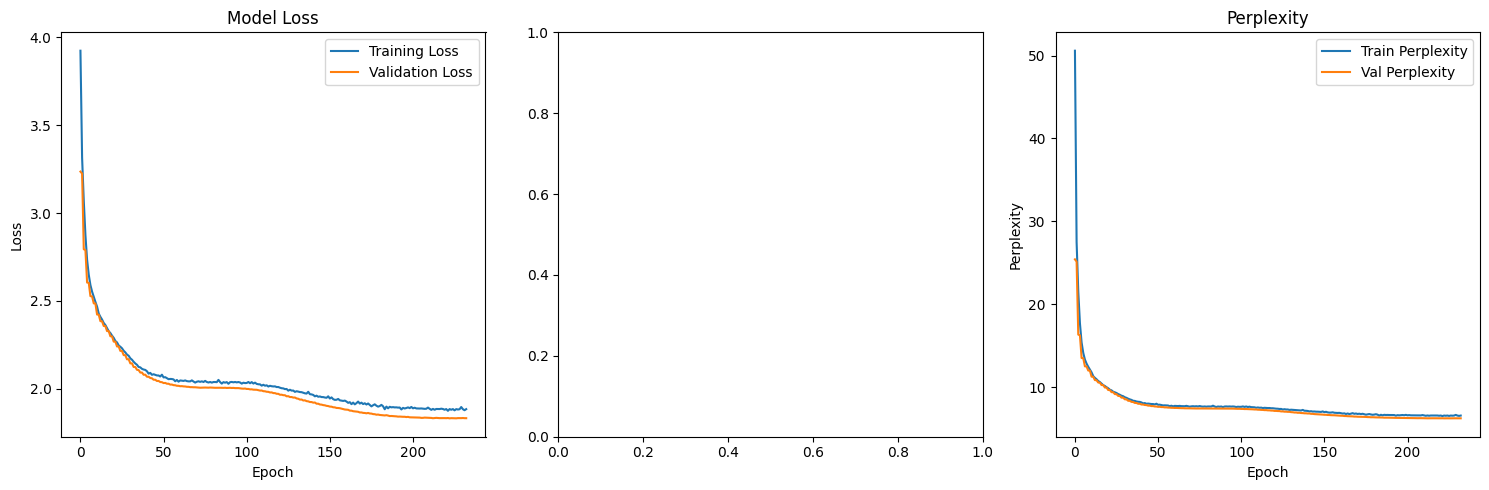

In [134]:
callbacks = [
    # Save model every epoch with epoch number
    keras.callbacks.ModelCheckpoint(
        filepath='/home/akshat/GPT_from_scratch/notebooks/rewrite_char_level_checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras',
        save_freq='epoch',
        save_best_only=False,
        verbose=1
    ),
    
    # Save best model separately
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # More reasonable early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Wait 50 epochs before stopping
        restore_best_weights=True,
        verbose=1
    ),

    keras.callbacks.CSVLogger('training_log.csv'),
    keras.callbacks.TensorBoard(
        log_dir="./char_logs", 
        histogram_freq=1, 
        profile_batch=0,
        write_graph=True
    )
]

# Training
print("Starting training...")
print(f"Total epochs: 100")
print(f"Steps per epoch: {steps_64}")
print(f"Total steps: {100 * steps_64}")

history = model.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=1000,
    steps_per_epoch=steps_64,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
if 'learning_rate' in history.history:
    plt.plot(history.history['learning_rate'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')

plt.subplot(1, 3, 3)
train_perplexity = [np.exp(loss) for loss in history.history['loss']]
val_perplexity = [np.exp(loss) for loss in history.history['val_loss']]
plt.plot(train_perplexity, label='Train Perplexity')
plt.plot(val_perplexity, label='Val Perplexity')
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.tight_layout()
plt.show()

In [303]:
# # Now training should work
# history = model.fit(
#     train_ds_32,
#     validation_data=val_ds_32,
#     epochs=50,
#     steps_per_epoch=steps_32,
#     callbacks=[
#         keras.callbacks.ModelCheckpoint(filepath='model_epoch_{epoch:02d}.keras',save_freq='epoch'),  # saves with epoch number   save_freq='epoch',                        # save every epoch    save_best_only=False,                     # save all epochs    verbose=1)
#         keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True, verbose=1),
#         keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, verbose=1),
#         keras.callbacks.CSVLogger('training_log.csv'),
#         keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1, profile_batch=0)
#     ]
# )

In [304]:
# pick a small dummy batch
import tensorflow as tf

dum_model = GPT(D_MODEL, VOCAB_SIZE, CONTEXT_LEN, 8, 0.00001, 4, 0.1)
dummy_input = tf.constant([[0] * CONTEXT_LEN], dtype=tf.int32)  # batch_size=1, length=CONTEXT_LEN
dum_model.save('model_epoch_1.keras')
# run the embeddings layer only
pos_layer = dum_model.get_layer('init_embeddings')  # or however your layer is named
try:
    pos_emb = pos_layer(dummy_input)
    print("✅ Positional embeddings are working. Shape:", pos_emb.shape)
except Exception as e:
    print("❌ Embedding test failed:", e)


✅ Positional embeddings are working. Shape: (1, 128, 64)


/home/akshat/ml/ml-venv/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [305]:
# Step 4: Save the final model
model.save('final_gpt_model.keras')
print("Model saved as 'final_gpt_model.keras'")

# Optional: Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved as 'training_history.pkl'")

# Step 5: Load model later (when needed)
def load_trained_model():
    """Load your saved model"""
    loaded_model = keras.models.load_model('best_model.keras')  # or 'final_gpt_model.keras'
    return loaded_model

# Usage for inference later:
# model = load_trained_model()

Model saved as 'final_gpt_model.keras'
Training history saved as 'training_history.pkl'


In [306]:
GPT_model.save('dum_GPT.keras')

In [307]:
import gradio as gr
import numpy as np
import tensorflow as tf
import keras

# token_to_id_dict = tokenize_and_build_vocabulary_tf([r'/home/akshat/GPT_from_scratch/text_data/jane_austen_clean.txt'])
id_to_token_dict = {id_val: token for token, id_val in token_to_id_dict.items()}

# Use the latest and best model - try the best_model.keras first, then latest checkpoint
try:
    model = keras.models.load_model(r'/home/akshat/GPT_from_scratch/notebooks/char_level_checkpoints/model_epoch_299_val_loss_0.0130.keras')
    print("✅ Loaded best_model.keras")
except:
    try:
        model = keras.models.load_model(r'/home/akshat/GPT_from_scratch/notebooks/char_level_checkpoints/model_epoch_163_val_loss_0.0303.keras')
        print("✅ Loaded epoch 163 model")
    except:
        model = keras.models.load_model(r'/home/akshat/GPT_from_scratch/notebooks/char_level_checkpoints/model_epoch_161_val_loss_0.0305.keras')
        print("✅ Loaded epoch 161 model")

CONTEXT_LEN = model._context_length  # Use the model's actual context length

# Debug: Print vocabulary info
print(f"Vocabulary size: {len(token_to_id_dict)}")
print(f"Model type: {type(model)}")

# Get model info from your custom GPT model
try:
    print(f"Model vocab size: {model._vocab_size}")
    print(f"Model context length: {model._context_length}")
    print(f"Model d_model: {model._d_model}")
    print(f"Model attention heads: {model._attention_heads}")
    print(f"Model decoder blocks: {model._decoder_blocks}")
    print(f"Vocab size matches model: {model._vocab_size == len(token_to_id_dict)}")
    
    if model._vocab_size != len(token_to_id_dict):
        print(f"⚠️  VOCAB SIZE MISMATCH! Model expects {model._vocab_size}, got {len(token_to_id_dict)}")
    
except Exception as e:
    print(f"Error getting model info: {e}")

print(f"Sample characters in vocab: {list(token_to_id_dict.keys())[:30]}")
print(f"Common characters present: {['a' in token_to_id_dict, 'e' in token_to_id_dict, ' ' in token_to_id_dict, '.' in token_to_id_dict]}")

# Check for problematic characters in the gibberish output
gibberish = "4ff.mtm 64m86rfstmfm?.fmmftms777mtmkf  tm7n7m77m77"
print(f"Checking gibberish characters:")
for char in set(gibberish):
    if char in token_to_id_dict:
        print(f"  '{char}' -> ID {token_to_id_dict[char]} ✓")
    else:
        print(f"  '{char}' -> NOT IN VOCAB ✗")

def encode_text(text, token_to_id_dict):
    """Encode text to token IDs using character-level tokenizer - convert to lowercase since dataset is lowercase"""
    # Convert input to lowercase since your dataset was lowercased
    text = text.lower()
    
    token_ids = []
    for char in text:
        if char in token_to_id_dict:
            token_ids.append(token_to_id_dict[char])
        else:
            print(f"Warning: '{char}' (ord: {ord(char)}) not in vocabulary, skipping")
            continue
    return token_ids

def decode_ids(token_ids, id_to_token_dict):
    """Decode token IDs back to text using character-level tokenizer"""
    text = ""
    for token_id in token_ids:
        if token_id in id_to_token_dict:
            text += id_to_token_dict[token_id]
        else:
            print(f"Warning: token ID {token_id} not in vocabulary")
    return text

def get_special_token_ids():
    """Get special token IDs - adjust these based on your tokenizer setup"""
    # For Jane Austen data, likely no special PAD token, use newline as EOS
    pad_id = token_to_id_dict.get('<PAD>', None)
    eos_id = token_to_id_dict.get('\n', None)  # Use newline as natural stopping point
    print(f"Special tokens - PAD: {pad_id}, EOS (newline): {eos_id}")
    return pad_id, eos_id

def top_k_sampling(logits, k=10):
    """Sample from logits using top-k sampling"""
    # Ensure we don't sample more than available tokens
    k = min(k, len(logits))
    
    values, indices = tf.math.top_k(logits, k=k)
    last_val = values[-1]
    filtered_logits = tf.where(
        logits < last_val,
        tf.fill(tf.shape(logits), float('-inf')),
        logits
    )
    probs = tf.nn.softmax(filtered_logits).numpy()
    
    # Add small epsilon to avoid numerical issues
    probs = probs + 1e-10
    probs = probs / np.sum(probs)
    
    return np.random.choice(len(probs), p=probs)

def generate_response(prompt, max_length=100, temperature=0.7, top_k=10, use_argmax=False):
    if not prompt.strip():
        return ""
    
    print(f"\n--- Generation Debug ---")
    print(f"Input prompt: '{prompt}' (will be lowercased)")
    
    # Tokenize prompt with character-level tokenizer
    input_tokens = encode_text(prompt, token_to_id_dict)
    print(f"Input tokens: {input_tokens}")
    print(f"Input tokens decoded back: '{decode_ids(input_tokens, id_to_token_dict)}'")
    
    if not input_tokens:
        return "Error: Could not tokenize input"
    
    # Truncate if longer than context length
    if len(input_tokens) > CONTEXT_LEN:
        input_tokens = input_tokens[-CONTEXT_LEN:]
    
    generated_tokens = input_tokens.copy()
    pad_id, eos_id = get_special_token_ids()
    
    print(f"Starting generation with {len(input_tokens)} input tokens...")
    
    for step in range(max_length):
        # Prepare inputs - pad from left to maintain most recent context
        input_ids = np.zeros((1, CONTEXT_LEN), dtype=np.int32)
        attention_mask = np.zeros((1, CONTEXT_LEN), dtype=np.int32)
        
        # Place tokens at the end of the context window
        current_len = min(len(generated_tokens), CONTEXT_LEN)
        start_idx = CONTEXT_LEN - current_len
        input_ids[0, start_idx:] = generated_tokens[-current_len:]
        attention_mask[0, start_idx:] = 1
        
        # Model forward pass
        try:
            logits = model((input_ids, attention_mask), training=False)
            next_token_logits = logits[0, -1, :]
            
            # Apply temperature
            if not use_argmax:
                next_token_logits = next_token_logits / temperature
        except Exception as e:
            print(f"Model forward pass error: {e}")
            break
        
        # Sample next token
        try:
            if use_argmax:
                # Use argmax (greedy) sampling for testing
                next_token = int(np.argmax(next_token_logits))
            else:
                # Use top-k sampling
                next_token = top_k_sampling(next_token_logits, k=top_k)
        except Exception as e:
            print(f"Sampling error: {e}")
            break
        
        # Debug: Print first few tokens
        if step < 10:
            sampled_char = id_to_token_dict.get(next_token, f"<UNK:{next_token}>")
            prob = float(tf.nn.softmax(next_token_logits)[next_token])
            print(f"Step {step}: Token {next_token} -> '{sampled_char}' (prob: {prob:.4f})")
        
        # Check if token is valid
        if next_token >= len(id_to_token_dict):
            print(f"Warning: Invalid token {next_token}, vocab size is {len(id_to_token_dict)}")
            break
        
        # Stop on special tokens
        if pad_id is not None and next_token == pad_id:
            print(f"Stopping at step {step}: hit PAD token")
            break
        if eos_id is not None and next_token == eos_id and step > 10:  # Don't stop too early
            print(f"Stopping at step {step}: hit EOS token (newline)")
            break
        
        generated_tokens.append(int(next_token))
        
        # Maintain sliding window
        if len(generated_tokens) > CONTEXT_LEN:
            generated_tokens = generated_tokens[-CONTEXT_LEN:]
    
    # Decode only the newly generated tokens
    new_tokens = generated_tokens[len(input_tokens):]
    response = decode_ids(new_tokens, id_to_token_dict)
    print(f"Generated {len(new_tokens)} new tokens: {new_tokens[:20]}...")  # Show first 20
    print(f"Generated response: '{response}'")
    print(f"--- End Debug ---\n")
    
    return response.strip()

def chat_fn(message, history, temperature, max_length, top_k, use_argmax):
    if not message.strip():
        return "", history
    
    bot_response = generate_response(message, max_length=max_length, temperature=temperature, top_k=top_k, use_argmax=use_argmax)
    history.append((message, bot_response))
    return "", history

# Quick test with the better model
print("Testing improved model:")
test_cases = ["the", "elizabeth", "it is a"]

for prompt in test_cases:
    print(f"\nTesting with: '{prompt}'")
    tokens = encode_text(prompt, token_to_id_dict)
    
    # Create model input
    input_ids = np.zeros((1, 256), dtype=np.int32)
    attention_mask = np.zeros((1, 256), dtype=np.int32)
    input_ids[0, -len(tokens):] = tokens
    attention_mask[0, -len(tokens):] = 1
    
    # Get model predictions
    logits = model((input_ids, attention_mask), training=False)
    next_token_logits = logits[0, -1, :]
    
    # Show top 5 predictions
    top_probs, top_indices = tf.nn.top_k(tf.nn.softmax(next_token_logits), k=5)
    print("Top 5 predictions:")
    for i in range(5):
        token_id = int(top_indices[i])
        prob = float(top_probs[i])
        char = id_to_token_dict.get(token_id, f"UNK_{token_id}")
        print(f"  {i+1}. '{char}' (ID: {token_id}) - {prob:.4f}")

# Test with longer context
print(f"\nTesting with longer Jane Austen context:")
long_prompt = "it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a"
tokens = encode_text(long_prompt, token_to_id_dict)
print(f"Context: '{long_prompt}'")
print(f"Context length: {len(tokens)} tokens")

# Use reasonable context length
context_tokens = tokens[-100:] if len(tokens) > 100 else tokens

input_ids = np.zeros((1, 256), dtype=np.int32)
attention_mask = np.zeros((1, 256), dtype=np.int32)
input_ids[0, -len(context_tokens):] = context_tokens
attention_mask[0, -len(context_tokens):] = 1

logits = model((input_ids, attention_mask), training=False)
next_token_logits = logits[0, -1, :]

top_probs, top_indices = tf.nn.top_k(tf.nn.softmax(next_token_logits), k=5)
print("Top 5 predictions after long context:")
for i in range(5):
    token_id = int(top_indices[i])
    prob = float(top_probs[i])
    char = id_to_token_dict.get(token_id, f"UNK_{token_id}")
    print(f"  {i+1}. '{char}' (ID: {token_id}) - {prob:.4f}")

with gr.Blocks(title="My Character-Level GPT Bot Trained in Tensorflow", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🤖 Chat with Akshat's Character-Level GPT Model")
    gr.Markdown("Ask me anything! I'm a GPT model trained from scratch with character-level tokenization on Jane Austen data. Be gentle with me :)")
    
    # Add vocab info
    gr.Markdown(f"**Model Info:** Vocabulary size: {len(token_to_id_dict)} characters")
    
    chatbot = gr.Chatbot(label="Conversation", height=400, show_copy_button=True)
    
    with gr.Row():
        msg = gr.Textbox(label="Your message", placeholder="Type your message here...", scale=4)
        send_btn = gr.Button("Send", scale=1, variant="primary")
    
    with gr.Row():
        temperature = gr.Slider(minimum=0.1, maximum=1.5, value=0.3, step=0.05, label="Temperature")
        max_length = gr.Slider(minimum=10, maximum=200, value=30, step=10, label="Max Length")
        top_k = gr.Slider(minimum=1, maximum=50, value=5, step=1, label="Top-K Sampling")
        use_argmax = gr.Checkbox(label="Use Argmax (Greedy) - for testing", value=True)
    
    clear_btn = gr.Button("Clear Chat", variant="secondary")
    
    # Event handlers
    msg.submit(chat_fn, [msg, chatbot, temperature, max_length, top_k, use_argmax], [msg, chatbot])
    send_btn.click(chat_fn, [msg, chatbot, temperature, max_length, top_k, use_argmax], [msg, chatbot])
    clear_btn.click(lambda: [], None, chatbot)

if __name__ == "__main__":
    demo.launch(
        share=True,          # Generate public share link
        server_name="127.0.0.1",
        server_port=6019,
        show_error=True
    )

ValueError: File not found: filepath=/home/akshat/GPT_from_scratch/notebooks/char_level_checkpoints/model_epoch_161_val_loss_0.0305.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
def generate_text(prompt, max_length=50, temperature=1.0):
    input_tokens = [token_to_id_dict.get(c, 0) for c in prompt if c in token_to_id_dict]
    if len(input_tokens) == 0:
        input_tokens = [0]

    if len(input_tokens) > CONTEXT_LEN:
        input_tokens = input_tokens[-CONTEXT_LEN:]

    input_ids = np.zeros((1, CONTEXT_LEN), dtype=np.int32)
    input_ids[0, -len(input_tokens):] = input_tokens

    attention_mask = np.zeros((1, CONTEXT_LEN), dtype=np.int32)
    attention_mask[0, -len(input_tokens):] = 1

    generated_tokens = input_tokens.copy()

    for _ in range(max_length):
        predictions = model.predict([input_ids, attention_mask], verbose=0)
        next_token_logits = predictions[0, -1, :] / temperature
        probabilities = tf.nn.softmax(next_token_logits).numpy()
        next_token = np.random.choice(len(probabilities), p=probabilities)

        if next_token == 0:
            break

        generated_tokens.append(next_token)

        # Update input_ids and attention_mask
        if len(generated_tokens) > CONTEXT_LEN:
            generated_tokens = generated_tokens[-CONTEXT_LEN:]

        input_ids[0, -len(generated_tokens):] = generated_tokens
        attention_mask[0, -len(generated_tokens):] = 1

    id_to_token = {v: k for k, v in token_to_id_dict.items()}
    return ''.join([id_to_token.get(t, '') for t in generated_tokens[len(input_tokens):]]).strip()


# Simple console loop
while True:
    prompt = input("You: ")
    if prompt.lower() in ["quit", "exit"]:
        break
    response = generate_text(prompt, max_length=50, temperature=0.8)
    print("GPT: ", response)

GPT:  VxxZEtRh5HHeYXZtxnhx5ICxxetRx5(ZxZMqx55xejhPxYW4Rx
GPT:  RcT2-LeJPeRHVpMKhzo37xBoxti
GPT:  qt-45HxGefn5ZZx48.UxMeTRuOLzRHxt
GPT:  RxHxtX5RmeMxHd2tZ


KeyboardInterrupt: Interrupted by user

In [ ]:
token_to_id_dict.keys()

dict_keys(['\n', ' ', '!', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

In [ ]:
id_to_token_dict.values()

dict_values(['\n', ' ', '!', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

In [ ]:
print(sinusoidal_lookup_table.shape)  # should be (CONTEXT_LEN, D_MODEL)

(128, 128)


In [ ]:
import tensorflow as tf
import keras
import numpy as np

# Model configuration
CONTEXT_LEN = 128
D_MODEL = 128
VOCAB_SIZE = 94

def test_sinusoidal_lookup_table():
    """Test the sinusoidal lookup table creation"""
    print("🔍 Testing sinusoidal lookup table creation...")
    try:
        sinusoidal_lookup_table = prepare_sinusoidal_lookup_table(D_MODEL, CONTEXT_LEN)
        print(f"✅ Sinusoidal lookup table created successfully. Shape: {sinusoidal_lookup_table.shape}")
        print(f"   Table type: {type(sinusoidal_lookup_table)}")
        print(f"   Table dtype: {sinusoidal_lookup_table.dtype}")
        return sinusoidal_lookup_table
    except Exception as e:
        print(f"❌ Sinusoidal lookup table creation failed: {e}")
        return None

def test_positional_embeddings(sinusoidal_lookup_table):
    """Test the positional embeddings layer"""
    print("\n🔍 Testing InitializePositionalEmbeddings layer...")
    
    try:
        # Create the layer
        pos_layer = InitializePositionalEmbeddings(
            d_model=D_MODEL,
            vocab_size=VOCAB_SIZE,
            sinusoidal_lookup_table=sinusoidal_lookup_table,
            name="test_pos_embeddings"
        )
        
        # Test input
        dummy_input = tf.constant([[1, 2, 3, 4, 5] + [0] * (CONTEXT_LEN - 5)], dtype=tf.int32)
        print(f"   Input shape: {dummy_input.shape}")
        
        # Forward pass
        pos_emb = pos_layer(dummy_input)
        print(f"✅ Positional embeddings working. Output shape: {pos_emb.shape}")
        print(f"   Expected shape: (1, {CONTEXT_LEN}, {D_MODEL})")
        
        # Check if embeddings are reasonable
        print(f"   Output range: [{tf.reduce_min(pos_emb):.4f}, {tf.reduce_max(pos_emb):.4f}]")
        print(f"   Output mean: {tf.reduce_mean(pos_emb):.4f}")
        
        return pos_layer, pos_emb
        
    except Exception as e:
        print(f"❌ Positional embeddings test failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def test_layer_normalization():
    """Test LayerNormalization layer"""
    print("\n🔍 Testing LayerNormalization layer...")
    
    try:
        ln = LayerNormalization(eps=1e-5, name="test_ln")
        test_input = tf.random.normal((2, CONTEXT_LEN, D_MODEL))
        
        output = ln(test_input)
        print(f"✅ LayerNormalization working. Input shape: {test_input.shape}, Output shape: {output.shape}")
        
        # Check normalization properties
        mean = tf.reduce_mean(output, axis=-1)
        var = tf.reduce_mean(tf.square(output - tf.expand_dims(mean, -1)), axis=-1)
        print(f"   Output mean (should be ~0): {tf.reduce_mean(mean):.6f}")
        print(f"   Output variance (should be ~1): {tf.reduce_mean(var):.6f}")
        
        return ln, output
        
    except Exception as e:
        print(f"❌ LayerNormalization test failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def test_your_self_attention():
    """Test YOUR custom SelfAttentionLayer"""
    print("\n🔍 Testing YOUR SelfAttentionLayer...")
    
    try:
        # Create your attention layer with correct parameter name
        attn_layer = SelfAttentionLayer(attention_heads=8, name="test_attention")
        
        # Prepare test inputs
        batch_size = 2
        seq_len = CONTEXT_LEN
        embeddings = tf.random.normal((batch_size, seq_len, D_MODEL))
        
        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = tf.ones((batch_size, seq_len), dtype=tf.float32)
        # Make some positions masked (set to 0)
        attention_mask = attention_mask.numpy()
        attention_mask[0, 50:] = 0  # Mask second half of first sequence
        attention_mask[1, 80:] = 0  # Mask last part of second sequence
        attention_mask = tf.constant(attention_mask)
        
        print(f"   Input embeddings shape: {embeddings.shape}")
        print(f"   Attention mask shape: {attention_mask.shape}")
        print(f"   Mask sample - seq 1: {attention_mask[0, :10].numpy()} ... {attention_mask[0, -10:].numpy()}")
        
        # Test with your layer's expected input format: (embeddings, mask)
        output = attn_layer([embeddings, attention_mask])
        print(f"✅ SelfAttentionLayer working. Output shape: {output.shape}")
        
        # Check output properties
        print(f"   Output range: [{tf.reduce_min(output):.4f}, {tf.reduce_max(output):.4f}]")
        print(f"   Output mean: {tf.reduce_mean(output):.4f}")
        print(f"   Output std: {tf.math.reduce_std(output):.4f}")
        
        # Verify attention heads are working
        print(f"   Attention heads: {attn_layer.attention_heads}")
        print(f"   d_head: {attn_layer.d_head}")
        print(f"   d_model: {attn_layer.d_model}")
        
        return attn_layer, output
        
    except Exception as e:
        print(f"❌ SelfAttentionLayer test failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def test_your_decoder_block():
    """Test YOUR custom DecoderBlock"""
    print("\n🔍 Testing YOUR DecoderBlock...")
    
    try:
        # Create your decoder block
        decoder = DecoderBlock(
            d_model=D_MODEL,
            n_heads=8,
            dropout_rate=0.1,
            epsilon=1e-5,
            name="test_decoder"
        )
        
        # Prepare test inputs
        batch_size = 2
        seq_len = CONTEXT_LEN
        test_input = tf.random.normal((batch_size, seq_len, D_MODEL))
        attention_mask = tf.ones((batch_size, seq_len), dtype=tf.float32)
        
        # Make some positions masked
        attention_mask = attention_mask.numpy()
        attention_mask[0, 60:] = 0
        attention_mask[1, 90:] = 0
        attention_mask = tf.constant(attention_mask)
        
        print(f"   Input shape: {test_input.shape}")
        print(f"   Attention mask shape: {attention_mask.shape}")
        
        # Test training=False
        output = decoder(test_input, attention_mask, training=False)
        print(f"✅ DecoderBlock working (training=False). Output shape: {output.shape}")
        
        # Test training=True
        output_train = decoder(test_input, attention_mask, training=True)
        print(f"✅ DecoderBlock working (training=True). Output shape: {output_train.shape}")
        
        # Check residual connections work (output should be different from input)
        input_mean = tf.reduce_mean(test_input)
        output_mean = tf.reduce_mean(output)
        print(f"   Input mean: {input_mean:.4f}, Output mean: {output_mean:.4f}")
        print(f"   Output range: [{tf.reduce_min(output):.4f}, {tf.reduce_max(output):.4f}]")
        
        return decoder, output
        
    except Exception as e:
        print(f"❌ DecoderBlock test failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def test_your_full_model(sinusoidal_lookup_table):
    """Test YOUR complete GPT model"""
    print("\n🔍 Testing YOUR complete GPT model...")
    
    try:
        # Create model exactly as you do
        model = GPT(
            d_model=D_MODEL,
            vocab_size=VOCAB_SIZE,
            context_length=CONTEXT_LEN,
            attention_heads=8,
            epsilon=1e-5,
            decoder_blocks=4,
            dropout_rate=0.1,
            sinusoidal_lookup_table=sinusoidal_lookup_table,
            name="test_gpt"
        )
        
        # Prepare test inputs
        token_ids = tf.constant([[1, 2, 3, 4, 5] + [0] * (CONTEXT_LEN - 5)], dtype=tf.int32)
        attention_mask = tf.ones((1, CONTEXT_LEN), dtype=tf.float32)
        
        # Set mask to 0 for padding tokens
        attention_mask = attention_mask.numpy()
        attention_mask[0, 5:] = 0  # Only first 5 tokens are real
        attention_mask = tf.constant(attention_mask)
        
        print(f"   Token IDs shape: {token_ids.shape}")
        print(f"   Token IDs sample: {token_ids[0, :10].numpy()}")
        print(f"   Attention mask shape: {attention_mask.shape}")
        print(f"   Mask sample: {attention_mask[0, :10].numpy()}")
        
        # Test forward pass
        logits = model([token_ids, attention_mask], training=False)
        print(f"✅ Full model forward pass successful!")
        print(f"   Output logits shape: {logits.shape}")
        print(f"   Expected shape: (1, {CONTEXT_LEN}, {VOCAB_SIZE})")
        
        # Check output properties
        print(f"   Logits range: [{tf.reduce_min(logits):.4f}, {tf.reduce_max(logits):.4f}]")
        print(f"   Logits mean: {tf.reduce_mean(logits):.4f}")
        
        # Test with different batch size
        token_ids_batch = tf.constant([
            [1, 2, 3] + [0] * (CONTEXT_LEN - 3),
            [4, 5, 6, 7] + [0] * (CONTEXT_LEN - 4)
        ], dtype=tf.int32)
        attention_mask_batch = tf.ones((2, CONTEXT_LEN), dtype=tf.float32)
        attention_mask_batch = attention_mask_batch.numpy()
        attention_mask_batch[0, 3:] = 0  # First seq has 3 real tokens
        attention_mask_batch[1, 4:] = 0  # Second seq has 4 real tokens
        attention_mask_batch = tf.constant(attention_mask_batch)
        
        logits_batch = model([token_ids_batch, attention_mask_batch], training=False)
        print(f"✅ Batch processing successful! Output shape: {logits_batch.shape}")
        
        # Test training mode
        logits_train = model([token_ids, attention_mask], training=True)
        print(f"✅ Training mode successful! Output shape: {logits_train.shape}")
        
        return model, logits
        
    except Exception as e:
        print(f"❌ Full model test failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def test_specific_embedding_issue():
    """Test the specific embedding issue you encountered"""
    print("\n🔍 Testing the specific embedding issue from your original code...")
    
    try:
        # Create model exactly as you did
        sinusoidal_lookup_table = prepare_sinusoidal_lookup_table(D_MODEL, CONTEXT_LEN)
        dum_model = GPT(D_MODEL, VOCAB_SIZE, CONTEXT_LEN, 8, 0.00001, 4, 0.1, sinusoidal_lookup_table)
        
        # Test exactly as you did
        dummy_input = tf.constant([[0] * CONTEXT_LEN], dtype=tf.int32)
        
        # Get the embeddings layer
        pos_layer = dum_model.get_layer('init_embeddings')
        
        # Run the embeddings layer
        pos_emb = pos_layer(dummy_input)
        print(f"✅ Your original embedding test now works! Shape: {pos_emb.shape}")
        print(f"   Input was all zeros: {dummy_input[0, :5].numpy()}")
        print(f"   Output range: [{tf.reduce_min(pos_emb):.4f}, {tf.reduce_max(pos_emb):.4f}]")
        
        return True
        
    except Exception as e:
        print(f"❌ Original embedding test still fails: {e}")
        import traceback
        traceback.print_exc()
        return False

def test_model_compilation_and_training(model):
    """Test model compilation and training capability"""
    print("\n🔍 Testing model compilation and training...")
    
    try:
        # Compile model
        model.compile(
            optimizer=keras.optimizers.AdamW(learning_rate=1e-4),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print("✅ Model compilation successful!")
        
        # Create dummy training data
        batch_size = 4
        dummy_x = tf.random.uniform((batch_size, CONTEXT_LEN), maxval=VOCAB_SIZE, dtype=tf.int32)
        dummy_mask = tf.ones((batch_size, CONTEXT_LEN), dtype=tf.float32)
        # Create some realistic masking
        for i in range(batch_size):
            seq_len = tf.random.uniform([], minval=10, maxval=CONTEXT_LEN, dtype=tf.int32)
            dummy_mask = dummy_mask.numpy()
            dummy_mask[i, seq_len:] = 0
            dummy_mask = tf.constant(dummy_mask)
        
        dummy_y = tf.random.uniform((batch_size, CONTEXT_LEN), maxval=VOCAB_SIZE, dtype=tf.int32)
        
        print(f"   Training data shapes: X={dummy_x.shape}, mask={dummy_mask.shape}, Y={dummy_y.shape}")
        
        # Test prediction
        predictions = model.predict([dummy_x, dummy_mask], verbose=0)
        print(f"✅ Model prediction successful! Predictions shape: {predictions.shape}")
        
        # Test training step
        loss = model.train_on_batch([dummy_x, dummy_mask], dummy_y)
        print(f"✅ Training step successful! Loss: {loss}")
        
        # Test model summary
        print(f"\n📊 Model has {model.count_params():,} parameters")
        
        return True
        
    except Exception as e:
        print(f"❌ Model compilation/training test failed: {e}")
        import traceback
        traceback.print_exc()
        return False

def run_all_tests_for_your_model():
    """Run all tests specifically for your model implementation"""
    print("🚀 Starting comprehensive testing for YOUR custom model implementation...\n")
    
    # Test 1: Sinusoidal lookup table
    sinusoidal_lookup_table = test_sinusoidal_lookup_table()
    if sinusoidal_lookup_table is None:
        print("❌ Cannot proceed without sinusoidal lookup table")
        return
    
    # Test 2: Positional embeddings
    pos_layer, pos_emb = test_positional_embeddings(sinusoidal_lookup_table)
    
    # Test 3: Layer normalization
    ln_layer, ln_output = test_layer_normalization()
    
    # Test 4: Your self attention
    attn_layer, attn_output = test_your_self_attention()
    
    # Test 5: Your decoder block
    decoder_layer, decoder_output = test_your_decoder_block()
    
    # Test 6: Your full model
    model, logits = test_your_full_model(sinusoidal_lookup_table)
    
    # Test 7: Your specific embedding issue
    embedding_issue_fixed = test_specific_embedding_issue()
    
    # Test 8: Model compilation and training
    compilation_success = False
    if model is not None:
        compilation_success = test_model_compilation_and_training(model)
    
    # Summary
    print("\n" + "="*70)
    print("🎯 TESTING SUMMARY FOR YOUR CUSTOM MODEL:")
    print("="*70)
    
    tests = [
        ("Sinusoidal Lookup Table", sinusoidal_lookup_table is not None),
        ("Positional Embeddings", pos_emb is not None),
        ("Layer Normalization", ln_output is not None),
        ("YOUR Self Attention Layer", attn_output is not None),
        ("YOUR Decoder Block", decoder_output is not None),
        ("YOUR Full Model Forward Pass", logits is not None),
        ("YOUR Original Embedding Issue", embedding_issue_fixed),
        ("Model Compilation & Training", compilation_success)
    ]
    
    passed = sum(1 for _, result in tests if result)
    total = len(tests)
    
    for test_name, result in tests:
        status = "✅ PASSED" if result else "❌ FAILED"
        print(f"{test_name:.<50} {status}")
    
    print(f"\n🏆 Overall: {passed}/{total} tests passed")
    
    if passed == total:
        print("🎉 All tests passed! Your model is working perfectly!")
        print("🚀 Your model is ready for training and inference!")
    elif passed >= total - 2:
        print("🎊 Almost all tests passed! Your model is mostly working correctly!")
        print("🔧 Check the failed tests above for minor issues.")
    else:
        print("⚠️  Some tests failed. Please fix the issues before training.")
    
    return model if logits is not None else None

# Run the tests
if __name__ == "__main__":
    final_model = run_all_tests_for_your_model()
    
    if final_model is not None:
        print(f"\n🎁 Model returned successfully!")
        print(f"   Total parameters: {final_model.count_params():,}")
        print(f"   Ready for: training, inference, and saving!")

🚀 Starting comprehensive testing for YOUR custom model implementation...

🔍 Testing sinusoidal lookup table creation...
✅ Sinusoidal lookup table created successfully. Shape: (128, 128)
   Table type: <class 'tensorflow.python.framework.ops.EagerTensor'>
   Table dtype: <dtype: 'float32'>

🔍 Testing InitializePositionalEmbeddings layer...
❌ Positional embeddings test failed: Unrecognized keyword arguments passed to InitializePositionalEmbeddings: {'sinusoidal_lookup_table': <tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  5.4030228e-01,  7.6172042e-01, ...,
         1.0000000e+00,  1.1547820e-04,  1.0000000e+00],
       [ 9.0929741e-01, -4.1614684e-01,  9.8704624e-01, ...,
         9.9999994e-01,  2.3095640e-04,  1.0000000e+00],
       ...,
       [-6.1604047e-01,  7.8771454e-01,  9.9029869e-01, ...,
         9.9986106e-01,  1.4434273e-02,  9

Traceback (most recent call last):
  File "/tmp/ipykernel_206177/3617421218.py", line 29, in test_positional_embeddings
    pos_layer = InitializePositionalEmbeddings(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_206177/3965528913.py", line 11, in __init__
    super().__init__(**kwargs)
  File "/home/akshat/ml/ml-venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 291, in __init__
    raise ValueError(
ValueError: Unrecognized keyword arguments passed to InitializePositionalEmbeddings: {'sinusoidal_lookup_table': <tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  5.4030228e-01,  7.6172042e-01, ...,
         1.0000000e+00,  1.1547820e-04,  1.0000000e+00],
       [ 9.0929741e-01, -4.1614684e-01,  9.8704624e-01, ...,
         9.9999994e-01,  2.3095640e-04,  1.0000000e+00],
       ...,
       [-6.1604047e-01

   Input shape: (2, 128, 128)
   Attention mask shape: (2, 128)
✅ DecoderBlock working (training=False). Output shape: (2, 128, 128)
✅ DecoderBlock working (training=True). Output shape: (2, 128, 128)
   Input mean: 0.0003, Output mean: -0.0041
   Output range: [-4.3376, 4.7553]

🔍 Testing YOUR complete GPT model...
❌ Full model test failed: Unrecognized keyword arguments passed to GPT: {'sinusoidal_lookup_table': <tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  5.4030228e-01,  7.6172042e-01, ...,
         1.0000000e+00,  1.1547820e-04,  1.0000000e+00],
       [ 9.0929741e-01, -4.1614684e-01,  9.8704624e-01, ...,
         9.9999994e-01,  2.3095640e-04,  1.0000000e+00],
       ...,
       [-6.1604047e-01,  7.8771454e-01,  9.9029869e-01, ...,
         9.9986106e-01,  1.4434273e-02,  9.9989581e-01],
       [ 3.2999083e-01,  9.4398415e-01,  7.474

Traceback (most recent call last):
  File "/tmp/ipykernel_206177/3617421218.py", line 186, in test_your_full_model
    model = GPT(
            ^^^^
  File "/tmp/ipykernel_206177/1791215164.py", line 64, in __init__
    super().__init__(**kwargs)
  File "/home/akshat/ml/ml-venv/lib/python3.12/site-packages/keras/src/models/model.py", line 158, in __init__
    Layer.__init__(self, *args, **kwargs)
  File "/home/akshat/ml/ml-venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 291, in __init__
    raise ValueError(
ValueError: Unrecognized keyword arguments passed to GPT: {'sinusoidal_lookup_table': <tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  5.4030228e-01,  7.6172042e-01, ...,
         1.0000000e+00,  1.1547820e-04,  1.0000000e+00],
       [ 9.0929741e-01, -4.1614684e-01,  9.8704624e-01, ...,
         9.9999994e-01,  2.30956

In [ ]:
def generate_response_from_bot(model, token_to_id_dict, prompt, max_length=100, temperature=0.7, context_len=128):
    """Generate text response from your GPT model"""
    
    # Tokenize input
    input_tokens = [token_to_id_dict.get(char, 0) for char in prompt]
    
    # Handle context length
    if len(input_tokens) > context_len:
        input_tokens = input_tokens[-context_len:]
    
    # Pad to context length
    input_ids = np.zeros(context_len, dtype=np.int32)
    if len(input_tokens) > 0:
        input_ids[-len(input_tokens):] = input_tokens
    
    # Create attention mask
    attention_mask = np.zeros(context_len, dtype=np.int32)
    if len(input_tokens) > 0:
        attention_mask[-len(input_tokens):] = 1
    
    # Prepare for model
    input_ids = np.expand_dims(input_ids, axis=0)
    attention_mask = np.expand_dims(attention_mask, axis=0)
    
    # Generate response token by token
    generated_tokens = input_tokens.copy()
    id_to_token = {v: k for k, v in token_to_id_dict.items()}
    
    for _ in range(max_length):
        # Get model predictions
        predictions = model.predict([input_ids, attention_mask], verbose=0)
        
        # Get last token logits (find the last non-zero position in attention mask)
        last_pos = np.sum(attention_mask[0]) - 1
        if last_pos < 0:
            last_pos = 0
        next_token_logits = predictions[0, last_pos, :] / temperature
        
        # Convert to probabilities
        probabilities = tf.nn.softmax(next_token_logits).numpy()
        
        # Sample next token
        next_token = np.random.choice(len(probabilities), p=probabilities)
        
        # Stop if we hit a stop token or newline
        if next_token == 0 or (next_token in token_to_id_dict.values() and id_to_token[next_token] == '\n'):
            break
            
        generated_tokens.append(next_token)
        
        # Update input for next iteration
        if len(generated_tokens) > context_len:
            generated_tokens = generated_tokens[-context_len:]
        
        # Create new input
        new_input_ids = np.zeros((1, context_len), dtype=np.int32)
        if len(generated_tokens) > 0:
            new_input_ids[0, -len(generated_tokens):] = generated_tokens
        
        new_attention_mask = np.zeros((1, context_len), dtype=np.int32)
        if len(generated_tokens) > 0:
            new_attention_mask[0, -len(generated_tokens):] = 1
        
        input_ids = new_input_ids
        attention_mask = new_attention_mask
    
    # Convert tokens back to text
    response_tokens = generated_tokens[len(input_tokens):]  # Only the new tokens
    response = ''.join([id_to_token.get(token, '') for token in response_tokens])
    
    return response.strip()

In [ ]:
generate_response_from_bot(model,token_to_id_dict,prompt = 'yoyo')

"]8'Vi3A;#sFöXöxr3ö][xöM6!dlwx—$pb:Orxx1JkW0:pöyyö;94œ!ööGHQöG:‘::$fwrg3Rg!R!/gxrgg/PöJIYPlö6öJ%6RpLp"

## 7. Notes & Next Steps
Document any observations, issues, or future plans here.